# Análisis Estadístico y Métricas de Caos de Series de Tiempo del Walker Tridimenional

## Alumno: Rodrigo Gerardo Trejo Arriaga

### Título de la Práctica: Estadísticas y Métricas de Caos en Series de Tiempo de un Caminante Aleatorio Tridimensional

Este segmento de la práctica explora las propiedades estadísticas y métricas de caos de las series de tiempo generadas por un caminante aleatorio tridimensional. Se calcularán métricas estadísticas como la media, mediana, entropía, kurtosis, varianza y desviación estándar para demostrar que los datos no siguen distribuciones de probabilidad convencionales como las normales, uniformes o gamma.

Además, se analizarán las métricas de caos de las series de tiempo, incluyendo los exponentes de Lyapunov, la dimensión de Kaplan-York y la dimensión de Grassberger-Procaccia, para caracterizar el comportamiento caótico de los datos.

---

Fecha de Entrega: **24 de Junio, 2024**


## Descripción del Problema

En este proyecto, se desarrolla una simulación de un caminante aleatorio tridimensional que se mueve dentro de un cubo. El objetivo es estudiar las propiedades estadísticas y caóticas de las series de tiempo generadas por este caminante. El caminante se desplaza siguiendo reglas sencillas basadas en un dataset, lo que permite realizar un análisis profundo de sus trayectorias y comportamientos.

### Funcionamiento del Caminante Aleatorio

El caminante aleatorio tridimensional se mueve dentro de un cubo y su desplazamiento está determinado por dos factores:
1. **Dirección del Movimiento**: Existen 26 posibles direcciones en un espacio tridimensional, incluyendo movimientos en los ejes principales (x, y, z) y sus combinaciones diagonales.
2. **Número de Pasos**: La cantidad de pasos que avanza en la dirección seleccionada.

Ambos factores son decididos de manera ponderada utilizando un dataset. En cada paso, se registran los siguientes datos en archivos de texto:
- **Dirección Seleccionada**: La dirección hacia la cual se mueve el caminante.
- **Número de Pasos**: La cantidad de pasos que avanza en la dirección seleccionada.
- **Posición Actual**: Las coordenadas (x, y, z) del caminante después de cada movimiento.
- **Choques con las Paredes del Cubo**: Indicación de si el caminante colisiona con alguna de las paredes del cubo.


### Modelos Caóticos

Para esta simulación, los caminantes fueron alimentados con datos generados por diferentes modelos caóticos, como los modelos logísticos de Feigenbaum, Hénon, Rössler y Lorenz. Esto proporciona una diversidad de patrones de movimiento caótico que serán analizados en las series de tiempo resultantes.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean, skew, kurtosis, mode
from scipy import stats

In [2]:
def cargar_csv(ruta:str, separador:str):

    try:
        with open(ruta, 'r', encoding='utf-8') as archivo:
            lineas = archivo.readlines()

            datos = [linea.strip().split(separador) for linea in lineas]
            
            datos = datos[0][:40000]
            
            if separador ==  ",":
                return [int(dato) for dato in datos]
            else:
                return [tuple(map(int, item.split(','))) for item in datos]
                
    except FileNotFoundError:
        print("El archivo no fue encontrado.")
        return []

def convertir_camelCase(text):
    cleaned_text = ''.join(char for char in text if char.isalnum() or char.isspace())
    words = cleaned_text.split()
    return words[0].lower() + ''.join(word.capitalize() for word in words[1:])

In [3]:
def graficar(x, t, plot_type='scatter', width=7, height=5, save_as_pdf=False, titulo="Diagrama de bifurcación cúbica de Feigenbaum"):
    """
    Crea un gráfico utilizando Matplotlib con estilo personalizado y márgenes ajustados.
    """
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['axes.facecolor'] = '#e9f0fb'
    plt.rcParams['grid.color'] = 'white'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = 1.5
    plt.rcParams['font.size'] = 10
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = 'black'

    fig, ax = plt.subplots(figsize=(width*1.5, height*1.5))
    fig.subplots_adjust(left=0.15, right=1, top=0.85, bottom=0.15)

    # Crear el gráfico
    if plot_type == 'scatter':
        ax.scatter(t, x, color='blue', marker='o', s=0.1)
    elif plot_type == 'line':
        ax.plot(t, x, color='blue', linewidth=1)
    elif plot_type == 'scatter_line':
        ax.scatter(t, x, color='blue', marker='o', s=0.1)
        ax.plot(t, x, color='blue', linewidth=0.5)

    ax.set_title(titulo, fontsize=16, loc='left', pad=20, color='black')
    ax.set_xlabel('Tasa de crecimiento t', fontsize=13, labelpad=15, color='black')
    ax.set_ylabel('Valor de x', fontsize=13, labelpad=15, color='black')
    ax.tick_params(axis='both', which='major', labelsize=10)

    if save_as_pdf:
        plt.savefig(f"{titulo.replace(' ', '_')}.pdf", format='pdf', dpi=300)

    plt.show()


In [4]:
def graficar_posicionesOcupadas(cube_size, positions, save_as_pdf=False, title="Porcentaje de Posiciones visitadas"):
    """
    Función para graficar el porcentaje de área ocupada por un caminante aleatorio en una cámara cúbica con estilo personalizado.
    
    Parámetros:
    - cube_size (int): tamaño de un lado de la cámara cúbica.
    - positions (list of tuples): lista de posiciones (x, y, z) por las que ha pasado el caminante.
    - save_as_pdf (bool): si es True, guarda el gráfico como PDF.
    - title (str): título del gráfico.
    """
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['axes.facecolor'] = '#e9f0fb'
    plt.rcParams['grid.color'] = 'white'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = 1.5
    plt.rcParams['font.size'] = 10
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['text.color'] = 'black'

    total_cells = cube_size ** 3

    unique_positions = set()

    occupied_percentage = []

    for position in positions:
        unique_positions.add(position)
        occupied_percentage.append(len(unique_positions) / total_cells * 100)

    fig, ax = plt.subplots(figsize=(7*1.5, 5*1.5))
    fig.subplots_adjust(left=0.15, right=1, top=0.85, bottom=0.15)

    ax.plot(list(range(1, len(occupied_percentage) + 1)), occupied_percentage, 'o-', color='blue', markersize=1, linewidth=1.5)
    ax.set_title(title, fontsize=16, loc='left', pad=20, color='black')
    ax.set_xlabel('Paso de Tiempo', fontsize=13, labelpad=15, color='black')
    ax.set_ylabel('Porcentaje de Área Ocupada (%)', fontsize=13, labelpad=15, color='black')
    ax.tick_params(axis='both', which='major', labelsize=10)

    if save_as_pdf:
        plt.savefig(f"{title.replace(' ', '_')}.pdf", format='pdf', dpi=300)

    plt.show()


In [5]:
def plotear_hist(array: np.ndarray, titulo: str, label_x: str, label_y: str, criterio: str = 'sturges', guardar=False) -> None:
    """
    Genera y guarda un histograma con estilos personalizados, colores aleatorios para cada barra,
    y el número de bins determinado por el criterio especificado.

    Args:
        array (np.ndarray): Array de Numpy con los datos que se quieren plasmar en el histograma.
        titulo (str): Título del histograma.
        label_x (str): Etiqueta del eje x del histograma.
        label_y (str): Etiqueta del eje y del histograma.
        ruta_img (str): Ruta donde se guardará la imagen del histograma.
        criterio (str): Método para calcular el número de bins ('sturges', 'freedman-diaconis', 'scott', 'raiz_cuadrada', 'rice').

    Returns:
        None: La función no retorna nada.
    """
    plt.style.use('dark_background')
    
    match criterio:
        case 'sturges':
            bins = int(1 + np.log2(len(array)))
        case 'freedman-diaconis':
            iqr = np.subtract(*np.percentile(array, [75, 25]))
            bin_width = 2 * iqr * len(array) ** (-1/3)
            bins = int(np.ptp(array) / bin_width)
        case 'scott':
            bin_width = 3.5 * np.std(array) * len(array) ** (-1/3)
            bins = int(np.ptp(array) / bin_width)
        case 'raiz_cuadrada':
            bins = int(np.sqrt(len(array)))
        case 'rice':
            bins = int(2 * len(array) ** (1/3))
        case 'secreto':
            bins = len(set(array))
        case _:
            raise ValueError("Criterio no reconocido. Usa 'sturges', 'freedman-diaconis', 'scott', 'raiz_cuadrada', o 'rice'.")

    n, bins, patches = plt.hist(array, bins=bins, alpha=0.75, rwidth=0.85)

    for patch in patches:
        plt.setp(patch, 'facecolor', np.random.rand(3,))
        
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title(titulo, fontsize=20, fontweight='bold', color=np.random.rand(3,))
    plt.xlabel(label_x, fontsize=15, fontstyle='italic', color=np.random.rand(3,))
    plt.ylabel(label_y, fontsize=15, fontstyle='italic', color=np.random.rand(3,))
    plt.ylim(0, max(n)*1.1)

    if guardar:
        ruta_img = f"{convertir_camelCase(titulo)}.pdf"
        plt.savefig(ruta_img, format='pdf', bbox_inches='tight')
    
    plt.show()


In [6]:
class DistribucionProbabilidad:
    def __init__(self, datos):
        self.datos = np.array(datos)
        self.n = len(datos)

    def media(self):
        return np.mean(self.datos, axis=0)
    
    def mediana(self):
        return np.median(self.datos, axis=0)
    
    def moda(self):
        mode_res = mode(self.datos, axis=0)
        """if len(mode_res.mode) > 0:
            return mode_res.mode[0]
        else:
            return np.nan"""
        return mode_res
                
    def media_geometrica(self):
        return gmean(self.datos, axis=0)
    
    def asimetria(self):
        return skew(self.datos, axis=0)
    
    def rango(self):
        return np.ptp(self.datos, axis=0)
    
    def desviacion_estandar(self):
        return np.std(self.datos, axis=0, ddof=1)
    
    def varianza(self):
        return np.var(self.datos, axis=0, ddof=1)
    
    def coeficiente_variacion(self):
        return self.desviacion_estandar() / self.media()
    
    def percentil(self, p):
        if 0 <= p <= 100:
            return np.percentile(self.datos, p, axis=0)
        else:
            raise ValueError("El percentil debe estar entre 0 y 100.")
    
    def curtosis(self):
        return kurtosis(self.datos, axis=0)
    
    def entropia(self):
        p, counts = np.unique(self.datos, return_counts=True)
        p = counts / len(self.datos)
        return -np.sum(p * np.log(p))
    
    def calcular_metricas(self, percentiles, cuartiles):
        resultados = {
            'Media': self.media(),
            'Mediana': self.mediana(),
            'Moda': self.moda(),
            'Media Geométrica': self.media_geometrica(),
            'Rango': self.rango(),
            'Desviación Estándar': self.desviacion_estandar(),
            'Varianza': self.varianza(),
            'Asimetría': self.asimetria(),
            'Coeficiente de Variación': self.coeficiente_variacion(),
            'Curtosis': self.curtosis(),
            'Entropía': self.entropia()
        }
        for p in percentiles:
            resultados[f'Percentil {p}'] = self.percentil(p)
        for q in cuartiles:
            resultados[f'Cuartil {q}'] = self.percentil(q * 25)
        
        # Convertir el diccionario a DataFrame de Pandas
        resultados_df = pd.DataFrame([resultados], index=['Valor'])
        
        # Redondear todos los valores a tres decimales
        resultados_df = resultados_df.round(3)

        # Transponer el DataFrame para hacerlo vertical
        resultados_df = resultados_df.transpose().reset_index()
        resultados_df.columns = ['Métrica', 'Valor']

        return resultados_df

class DistribucionProbabilidadVector(DistribucionProbabilidad):
    def __init__(self, datos):
        super().__init__(datos)
        
    def entropia(self):
        # Inicializa un array para guardar la entropía de cada componente
        entropias = np.zeros(3)
        # Calcula la entropía para cada dimensión (columna)
        for i in range(3):  # Asumiendo que tienes 3 dimensiones: X, Y, Z
            p, counts = np.unique(self.datos[:, i], return_counts=True)
            p = counts / len(self.datos)
            entropias[i] = -np.sum(p * np.log(p))
        return tuple(entropias)
        
    def calcular_metricas(self):
        # Calcular y redondear cada métrica antes de convertirla en tupla
        media = tuple(np.round(self.media(), 3))
        mediana = tuple(np.round(self.mediana(), 3))
        moda = tuple(np.round(self.moda(), 3))
        media_geometrica = tuple(np.round(self.media_geometrica(), 3))
        rango = tuple(np.round(self.rango(), 3))
        desviacion_estandar = tuple(np.round(self.desviacion_estandar(), 3))
        varianza = tuple(np.round(self.varianza(), 3))
        asimetria = tuple(np.round(self.asimetria(), 3))
        coeficiente_variacion = tuple(np.round(self.coeficiente_variacion(), 3))
        curtosis = tuple(np.round(self.curtosis(), 3))
        entropia = tuple(np.round(self.entropia(), 3))

        resultados = {
            'Media': media,
            'Mediana': mediana,
            'Moda': moda,
            'Media Geométrica': media_geometrica,
            'Rango': rango,
            'Desviación Estándar': desviacion_estandar,
            'Varianza': varianza,
            'Asimetría': asimetria,
            'Coeficiente de Variación': coeficiente_variacion,
            'Curtosis': curtosis,
            'Entropía': entropia
        }
        
        # Convertir el diccionario a DataFrame de Pandas
        resultados_df = pd.DataFrame([resultados], index=['Valor'])
        
        # Transponer el DataFrame para hacerlo vertical
        resultados_df = resultados_df.transpose().reset_index()
        resultados_df.columns = ['Métrica', 'Valor']

        return resultados_df

In [7]:
def lyapunov_spectrum_n(datos, window_size):
    """
    Calcula los exponentes de Lyapunov para cualquier serie temporal.

    :param datos: Serie temporal del sistema.
    :param window_size: Tamaño de la ventana para el cálculo del exponente de Lyapunov.
    :return: Array con los exponentes de Lyapunov.
    """
    n = len(datos)
    n_windows = n // window_size
    exponentes_lyapunov = []

    # Calcula la derivada numérica usando diferencias finitas
    derivadas = np.diff(datos) / np.diff(np.arange(len(datos)))

    # Añade un valor de derivada al final para mantener el tamaño
    derivadas = np.append(derivadas, derivadas[-1])

    for j in range(n_windows):
        suma_logaritmos_derivadas = 0
        for i in range(window_size):
            derivada = derivadas[j * window_size + i]
            suma_logaritmos_derivadas += np.log(abs(derivada))
        
        exponente_lyapunov = (1 / window_size) * suma_logaritmos_derivadas
        exponentes_lyapunov.append(exponente_lyapunov)

    return np.array(exponentes_lyapunov)

In [8]:
def lyapunov_spectrum_n(datos, window_size):
    """
    Calcula los exponentes de Lyapunov para cualquier serie temporal.

    :param datos: Serie temporal del sistema.
    :param window_size: Tamaño de la ventana para el cálculo del exponente de Lyapunov.
    :return: Array con los exponentes de Lyapunov.
    """
    n = len(datos)
    n_windows = n // window_size
    exponentes_lyapunov = []

    # Calcula la derivada numérica usando diferencias finitas
    derivadas = np.diff(datos) / np.diff(np.arange(len(datos)))

    # Añade un valor de derivada al final para mantener el tamaño
    derivadas = np.append(derivadas, derivadas[-1])

    # Evitar valores de cero en las derivadas
    derivadas[derivadas == 0] = np.finfo(float).eps

    for j in range(n_windows):
        suma_logaritmos_derivadas = 0
        for i in range(window_size):
            derivada = derivadas[j * window_size + i]
            suma_logaritmos_derivadas += np.log(abs(derivada))
        
        exponente_lyapunov = (1 / window_size) * suma_logaritmos_derivadas
        exponentes_lyapunov.append(exponente_lyapunov)

    return np.array(exponentes_lyapunov)

def plot_lyapunov_spectrum(datos, window_size, folder, metrica):
    """
    Grafica la serie temporal y el espectro de exponentes de Lyapunov.

    :param datos: Serie temporal del sistema.
    :param window_size: Tamaño de la ventana para el cálculo del exponente de Lyapunov.
    :param folder: Nombre de la carpeta para el título de la gráfica.
    :param metrica: Nombre de la métrica para el título de la gráfica.
    """
    lyapunov_exponents = lyapunov_spectrum_n(datos, window_size)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Serie Temporal', color=color)
    ax1.scatter(np.arange(len(datos)), datos, color=color, label='Serie Temporal', marker='o', s=0.1)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Exponente de Lyapunov', color=color)
    ax2.plot(np.arange(len(lyapunov_exponents)) * window_size + window_size // 2, lyapunov_exponents, color=color, label='Exponente de Lyapunov')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.suptitle(f'Serie Temporal y Espectro de Exponentes de Lyapunov de {folder} - {metrica}')
    fig.tight_layout()
    plt.show()
    
    return lyapunov_exponents


In [9]:
def dimension_kaplan_yorke(exponentes_lyapunov):
    """
    Calcula la dimensión de Kaplan-Yorke dada una lista de exponentes de Lyapunov.

    :param exponentes_lyapunov: Lista de exponentes de Lyapunov.
    :return: Dimensión de Kaplan-Yorke.
    """
    exponentes_lyapunov = sorted(exponentes_lyapunov, reverse=True)
    
    if len(exponentes_lyapunov) < 3:
        raise ValueError("Se requieren al menos 3 exponentes de Lyapunov para calcular la dimensión de Kaplan-Yorke con esta fórmula.")

    suma = sum(exponentes_lyapunov[:2])
    
    if exponentes_lyapunov[2] == 0:
        return float('inf')  # O maneja el caso de manera adecuada
    else:
        dk_y = 2 + (suma / abs(exponentes_lyapunov[2]))
    
    return dk_y


## Caminante de Feigenbaum

![Caminante de Feigenbaum](datos//Feigenbaum/Feigenbaum.png)

### Dirección

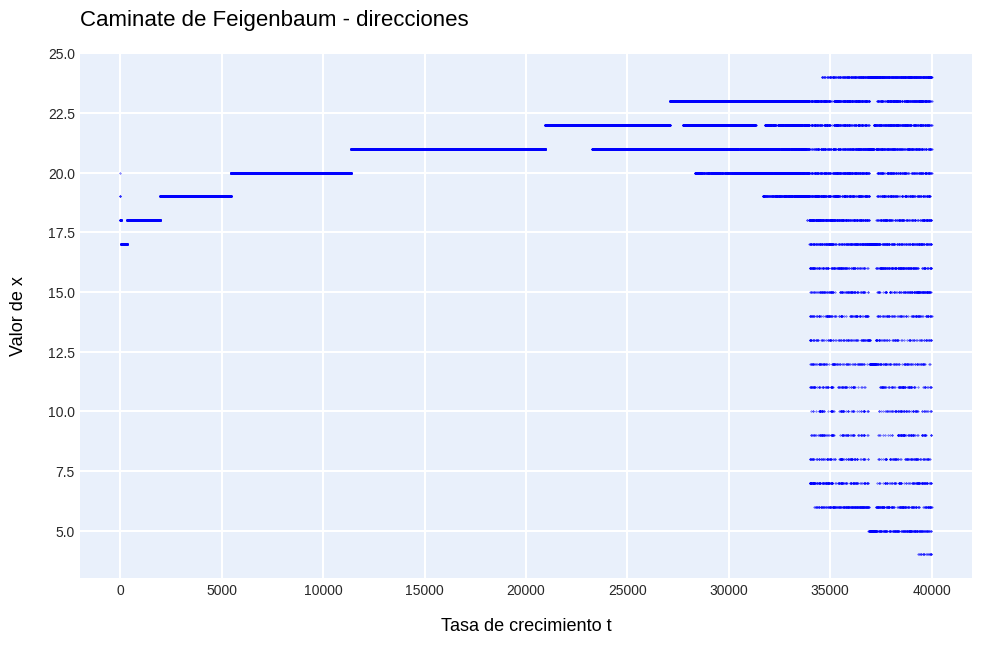

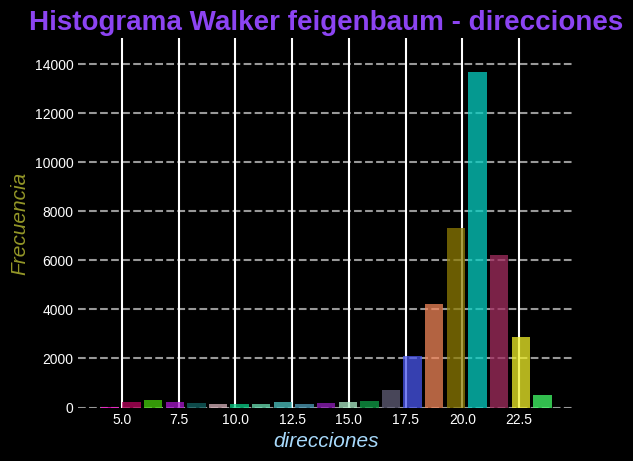

In [10]:
modelo = "feigenbaum"
metrica = "direcciones"
folder = "Feigenbaum"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {convertir_camelCase(modelo)} - {metrica}", metrica, "Frecuencia", criterio="secreto")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])


##### Interpretación de las Métricas

 Media (20.068): La media es el valor promedio de las direcciones seleccionadas por el caminante. En este caso, la media de 20.068 indica que, en promedio, las direcciones elegidas están alrededor del índice 20 en el rango de posibles direcciones.

 Mediana (21.0): La mediana es el valor que divide el conjunto de datos en dos partes iguales. En este caso, la mediana de 21.0 sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 21 y la otra mitad son mayores o iguales a 21.

 Moda (21, 13678): La moda es el valor que aparece con más frecuencia en el conjunto de datos. Aquí, la dirección 21 es la más frecuente, seleccionada 13,678 veces. Esto indica una preferencia significativa del caminante por moverse en la dirección 21.

 Desviación Estándar (2.965): La desviación estándar mide la dispersión de los valores alrededor de la media. Una desviación estándar de 2.965 sugiere que las direcciones seleccionadas por el caminante tienden a variar en aproximadamente ±3 direcciones alrededor de la media (20.068). Esto indica una cierta concentración alrededor de la media, pero con variabilidad.

 Varianza (8.788): La varianza es el cuadrado de la desviación estándar y proporciona una medida de la dispersión de los datos. Una varianza de 8.788 confirma la observación de la desviación estándar, indicando una variabilidad moderada en las direcciones seleccionadas.

 Asimetría (-2.969):  La asimetría mide la simetría de la distribución de los datos. Un valor de asimetría de -2.969 indica que la distribución está sesgada hacia la izquierda. Esto significa que hay una cola más larga en el lado izquierdo de la distribución, sugiriendo que hay algunas direcciones de menor índice que se seleccionan con menor frecuencia, pero de manera más dispersa.

 Curtosis (10.539): La curtosis mide la "puntiagudez" de la distribución de los datos. Un valor de curtosis de 10.539 indica que la distribución es muy leptocúrtica, lo que significa que tiene una alta concentración de valores en torno a la media y colas más largas. Esto sugiere que, además de la moda, hay una concentración significativa de valores alrededor de la media y la mediana, con menos valores extremos.

 Entropía (1.996): La entropía mide la incertidumbre o aleatoriedad en los datos. Una entropía de 1.996 indica un nivel moderado de incertidumbre en la selección de direcciones, lo que sugiere que aunque hay una preferencia por ciertas direcciones (como la dirección 21), hay también variabilidad en la selección de otras direcciones.


#### Exponentes de Lyapounov y Kaplan York

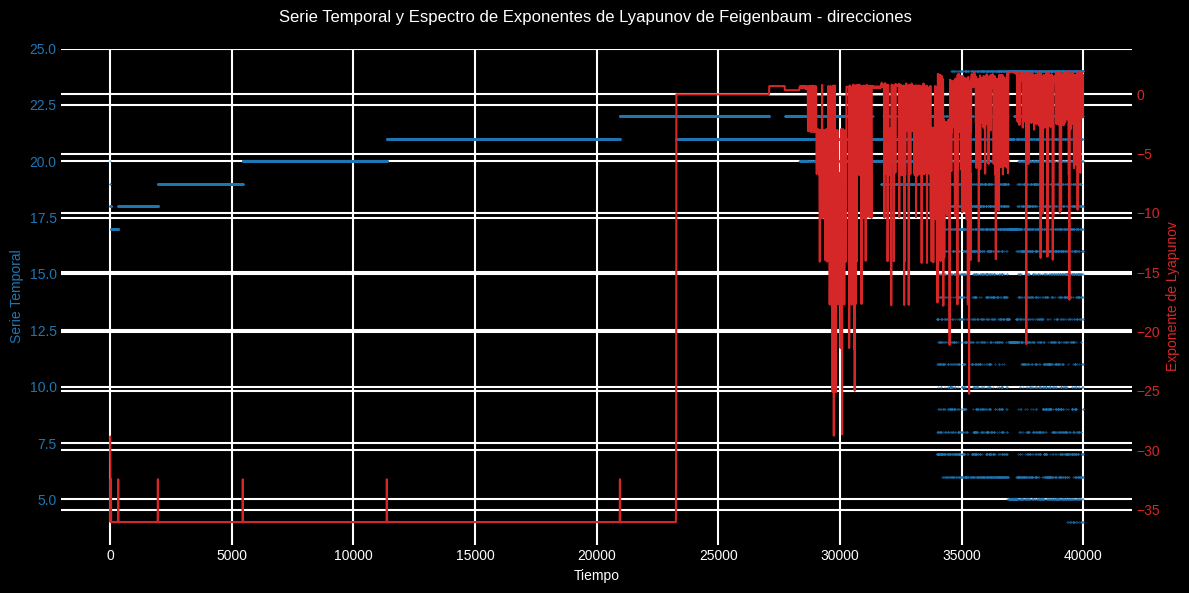

La dimension de Kaplan York es: 4.048835893117703


In [11]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")


La gráfica muestra la evolución temporal de las direcciones seleccionadas por el caminante aleatorio, superpuesta con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Se observa una tendencia de las direcciones alrededor de valores específicos (mayores a 15), con un comportamiento más errático hacia el final de la serie.
- **Exponentes de Lyapunov**: Los exponentes de Lyapunov negativos indican estabilidad local y sensibilidad a las condiciones iniciales. La variabilidad en estos valores a lo largo del tiempo refleja la naturaleza caótica del sistema.
- **Dimensión de Kaplan Yorke**: 4.048835893117703. Este valor sugiere una complejidad en la dinámica del sistema, con una alta dimensión fractal que es típica en sistemas caóticos.


### Distancia

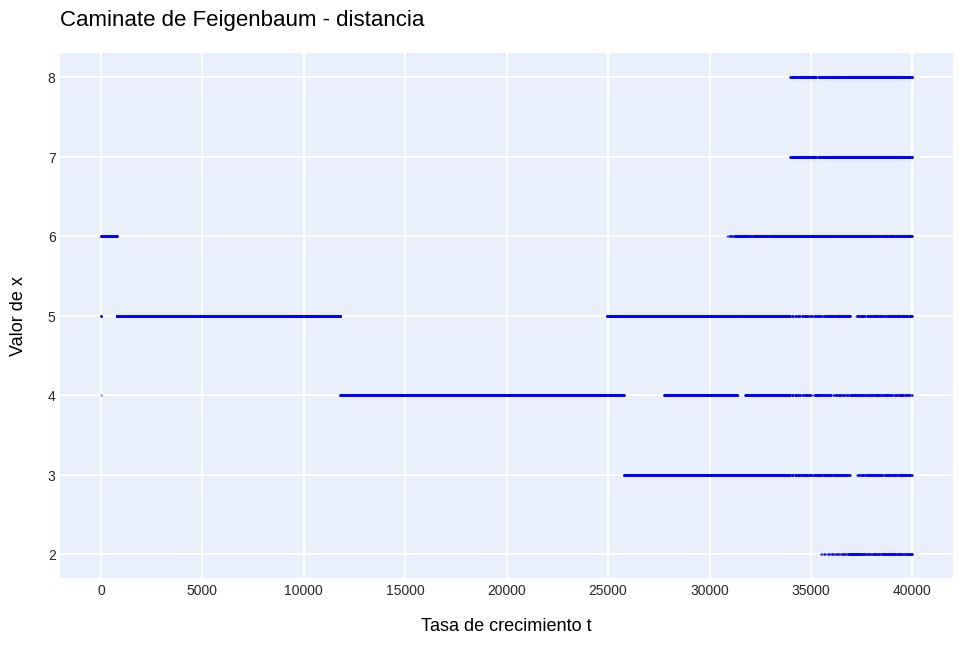

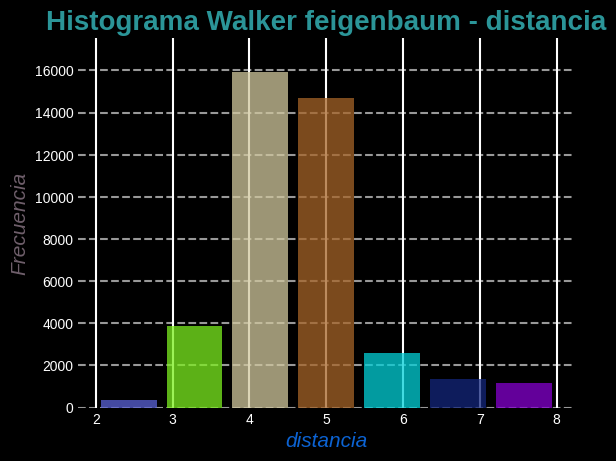

In [12]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {convertir_camelCase(modelo)} - {metrica}", metrica, "Frecuencia", criterio="secreto")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Exponentes de Lyapounov Y Kaplan Yorke

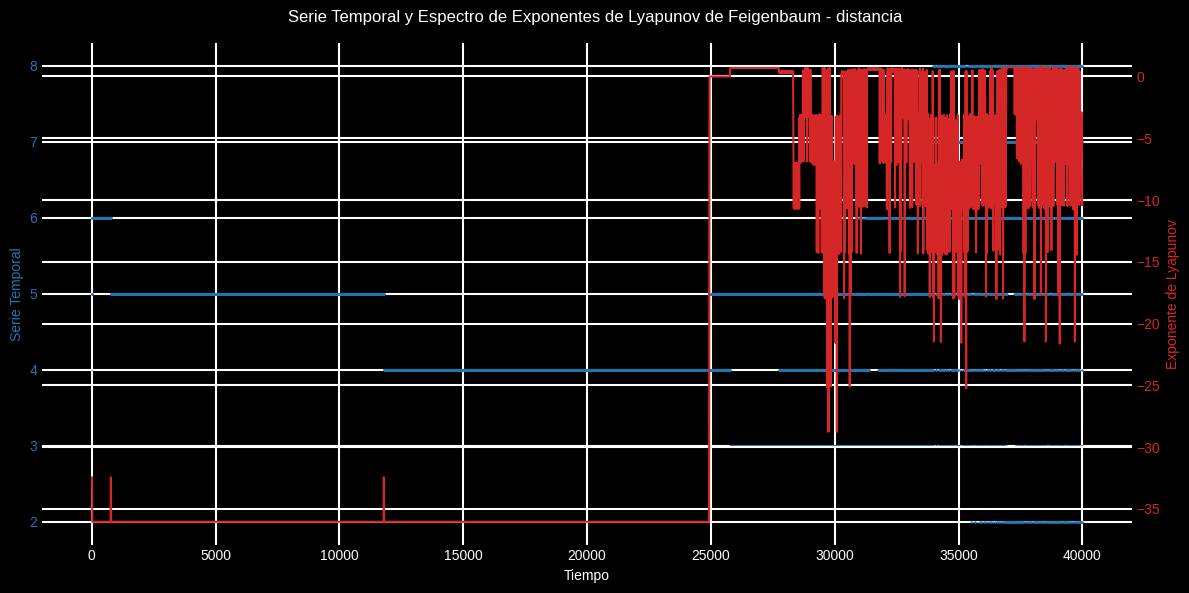

La dimension de Kaplan York es: 4.155383905224292


In [13]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

Esta gráfica ilustra la evolución de las distancias recorridas en cada paso por el caminante aleatorio, junto con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Las distancias se concentran en valores bajos (1 a 4), lo que sugiere que el caminante realiza pequeños desplazamientos con más frecuencia.
- **Exponentes de Lyapunov**: Al igual que en la gráfica de direcciones, los exponentes negativos predominan, indicando regiones de estabilidad y comportamiento caótico.
- **Dimensión de Kaplan Yorke**: 4.15538905224292. Este valor refuerza la idea de una dinámica compleja y caótica en el movimiento del caminante.


### Choques

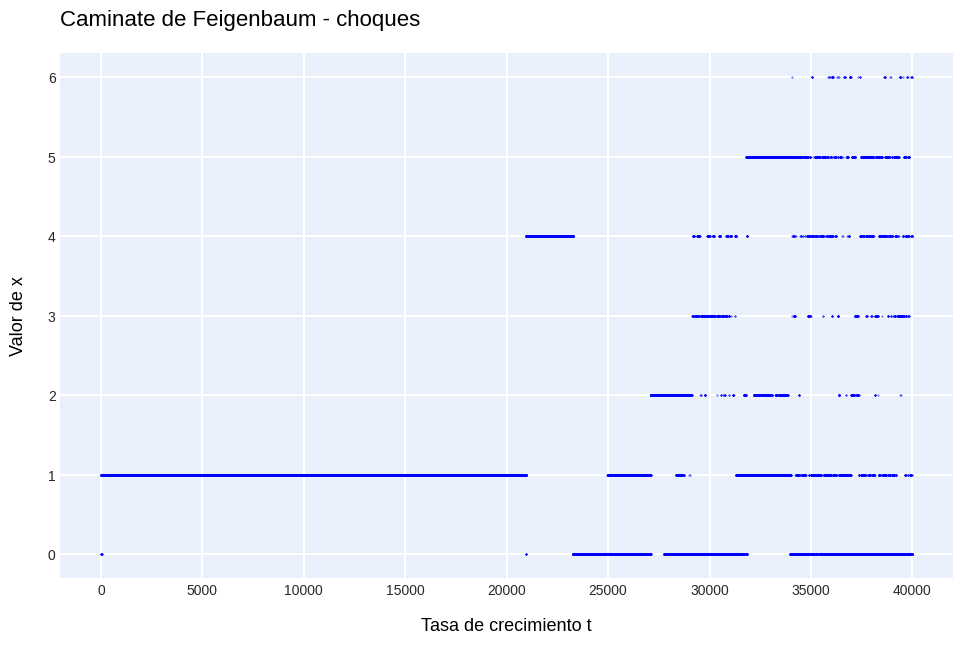

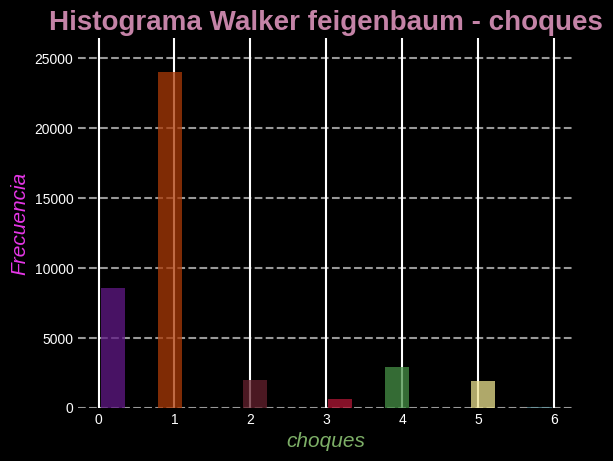

In [14]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {convertir_camelCase(modelo)} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

 Media (1.282): La media es el valor promedio de los choques que experimenta el caminante. En este caso, la media de 1.282 indica que, en promedio, el caminante choca con las paredes del cubo aproximadamente 1.28 veces por movimiento.

 Mediana (1.0):  La mediana es el valor que divide el conjunto de datos en dos partes iguales. En este caso, la mediana de 1.0 sugiere que la mitad de los choques son menores o iguales a 1 y la otra mitad son mayores o iguales a 1.

 Moda (1, 24049): La moda es el valor que aparece con más frecuencia en el conjunto de datos. Aquí, el número de choques de 1 es el más frecuente, ocurriendo 24,049 veces. Esto indica una fuerte tendencia del caminante a chocar con las paredes del cubo una vez por movimiento.

 Desviación Estándar (1.304):  La desviación estándar mide la dispersión de los valores alrededor de la media. Una desviación estándar de 1.304 sugiere que el número de choques tiende a variar en aproximadamente ±1.3 alrededor de la media (1.282). Esto indica una cierta variabilidad en el número de choques, aunque la mayoría están cerca de la media.

 Varianza (1.701): La varianza es el cuadrado de la desviación estándar y proporciona una medida de la dispersión de los datos. Una varianza de 1.701 confirma la observación de la desviación estándar, indicando una variabilidad moderada en el número de choques.

 Asimetría (1.678): La asimetría mide la simetría de la distribución de los datos. Un valor de asimetría de 1.678 indica que la distribución está sesgada hacia la derecha. Esto significa que hay una cola más larga en el lado derecho de la distribución, sugiriendo que hay algunos movimientos con un mayor número de choques que ocurren con menor frecuencia.

 Curtosis (2.073): La curtosis mide la "puntiagudez" de la distribución de los datos. Un valor de curtosis de 2.073 indica que la distribución es leptocúrtica, lo que significa que tiene una concentración de valores en torno a la media y colas más largas. Esto sugiere que, además de la moda, hay una concentración significativa de valores alrededor de la media y la mediana, con menos valores extremos.

 Entropía (1.192): La entropía mide la incertidumbre o aleatoriedad en los datos. Una entropía de 1.192 indica un nivel moderado de incertidumbre en la ocurrencia de choques, lo que sugiere que aunque hay una preferencia por ciertos números de choques (como 1 choque), hay también variabilidad en la ocurrencia de otros números de choques.


#### Exponentes de Lyapounov y Kaplan Yorke


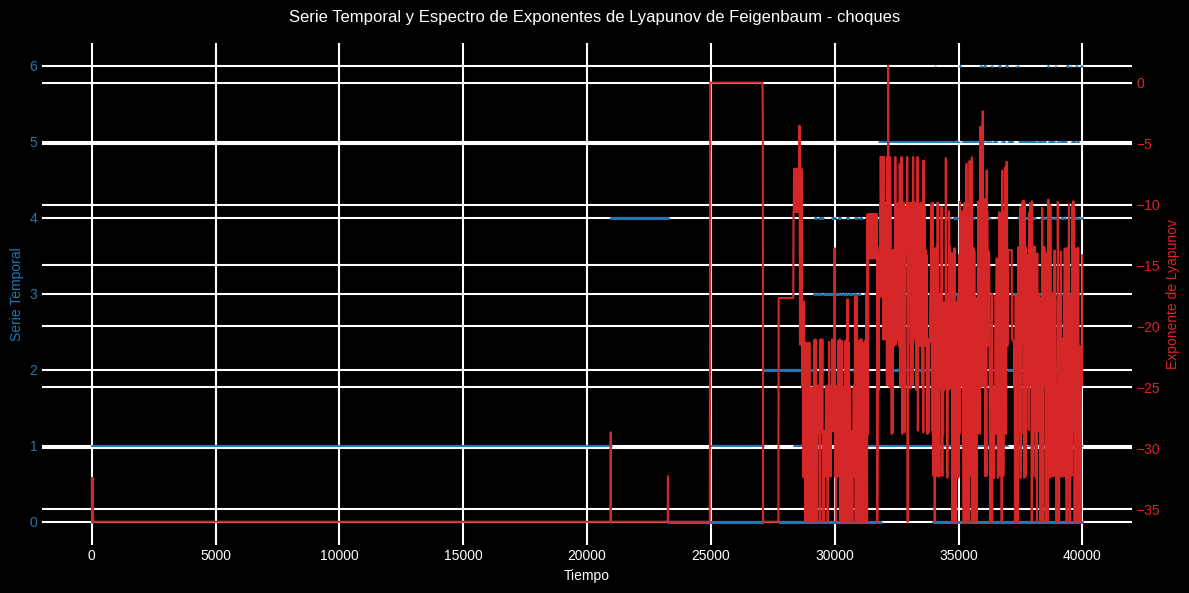

La dimension de Kaplan York es: inf


In [15]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

La gráfica muestra el comportamiento de los choques del caminante con las paredes del cubo, en combinación con los exponentes de Lyapunov.

- **Serie Temporal**: La mayoría de los datos indican choques con la pared etiquetada como '0' (sin choque), con algunos episodios de choques con otras paredes, especialmente hacia el final del tiempo.
- **Exponentes de Lyapunov**: Los exponentes negativos y su variabilidad reflejan el carácter caótico del sistema y su sensibilidad a las condiciones iniciales.
- **Dimensión de Kaplan Yorke**: Inf. Este resultado indica un nivel muy alto de complejidad y caos en el sistema, lo que podría estar relacionado con la alta frecuencia y variabilidad de los choques.


### Posiciones

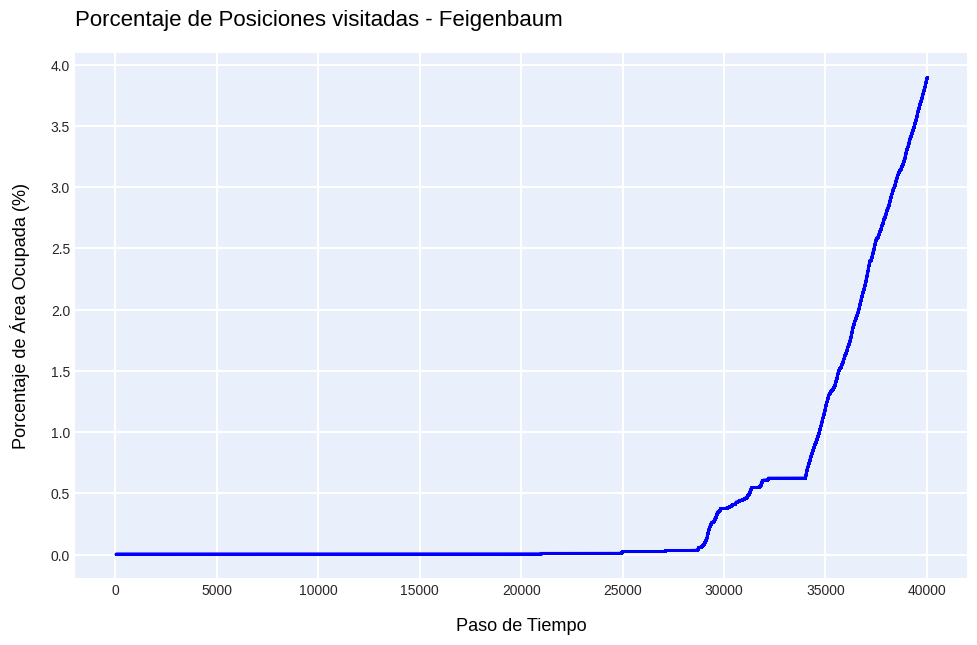

In [16]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")
graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

 Media (19.862, 7.186, 36.397) : La media sugiere que, en promedio, las posiciones visitadas por el caminante son bastante variadas en el espacio tridimensional, con un sesgo hacia posiciones específicas dentro del cubo.

 Mediana (20.0, 0.0, 49.0): La mediana indica que la mitad de las posiciones visitadas se encuentran por debajo de estos valores, sugiriendo una concentración de posiciones visitadas en ciertas áreas del cubo.

 Moda ([20, 0, 49], [22135, 24255, 22538]): La moda muestra que hay posiciones específicas (como [20, 0, 49]) que son visitadas con mucha más frecuencia que otras, lo que indica una preferencia o un patrón repetitivo en el movimiento del caminante.

 Rango (49, 49, 49):  El rango de 49 en cada dimensión indica que el caminante cubre prácticamente todo el cubo, sugiriendo que no hay restricciones significativas en su movimiento y que eventualmente explora la mayoría del espacio disponible.

 Desviación Estándar (12.46, 13.25, 18.253): La desviación estándar muestra una variabilidad considerable en las posiciones visitadas, con la mayor variabilidad en la tercera dimensión, lo que sugiere una exploración más dispersa en esa dirección.

 Varianza (155.256, 175.568, 333.158):  La varianza refuerza la observación de la desviación estándar, mostrando una dispersión significativa en las posiciones visitadas, especialmente en la tercera dimensión.

 Asimetría (0.662, 1.898, -1.072)  La asimetría sugiere que la distribución de posiciones visitadas tiene diferentes sesgos en cada dimensión, con una distribución más equilibrada en la primera y segunda dimensiones, y una distribución sesgada hacia valores menores en la tercera dimensión.

 Coeficiente de Variación (0.627, 1.844, 0.501): El coeficiente de variación indica que hay una relativa consistencia en la exploración a lo largo de las dimensiones, con la segunda dimensión mostrando más variabilidad relativa.

 Curtosis (0.63, 2.51, -0.506): La curtosis revela que las posiciones visitadas tienen distribuciones variadas, con una distribución más plana en la primera y tercera dimensiones, y una distribución más puntiaguda en la segunda dimensión.

 Entropía (2.116, 1.876, 2.014): La entropía indica un nivel moderado de incertidumbre en la exploración de posiciones, con cierta aleatoriedad en el movimiento del caminante dentro del cubo.

## Caminante de Feigenbaum Exponencial

![Exponencial](datos/FeigenbaumExponencial/FeigenbaumExponencial2.png)


### Direcciones

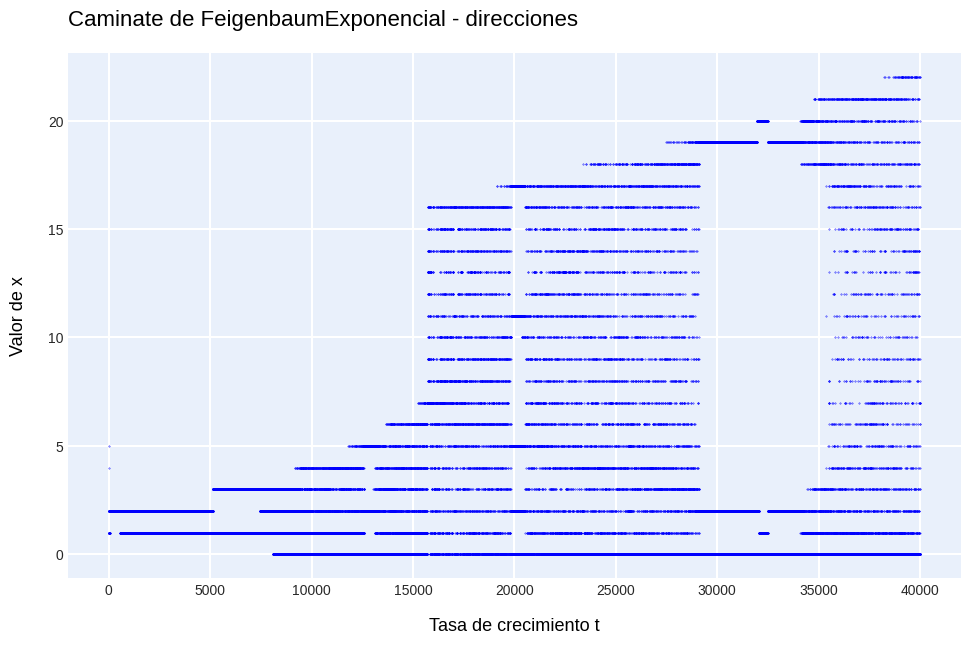

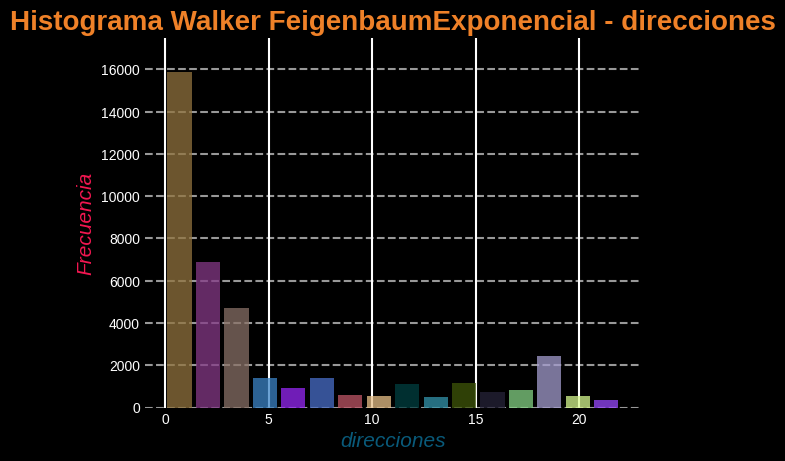

In [17]:
modelo = "feigenbaumexponencial"
metrica = "direcciones"
folder = "FeigenbaumExponencial"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

 Media (4.904): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 4.904.

 Mediana (2.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 2 y la otra mitad son mayores o iguales a 2.

 Moda (0, 8224): La moda muestra que la dirección 0 es la más frecuente, seleccionada 8,224 veces, lo que indica una preferencia significativa del caminante por moverse en esta dirección.

 Desviación Estándar (6.123: La desviación estándar de 6.123 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

 Varianza (37.497): La varianza de 37.497 confirma una alta dispersión en las direcciones seleccionadas.

 Asimetría (1.354): La asimetría de 1.354 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

 Curtosis (0.436): La curtosis de 0.436 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

 Entropía (2.492): La entropía de 2.492 indica un alto nivel de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.

#### EXponentes de Lyapounov y Kaplan Yorke

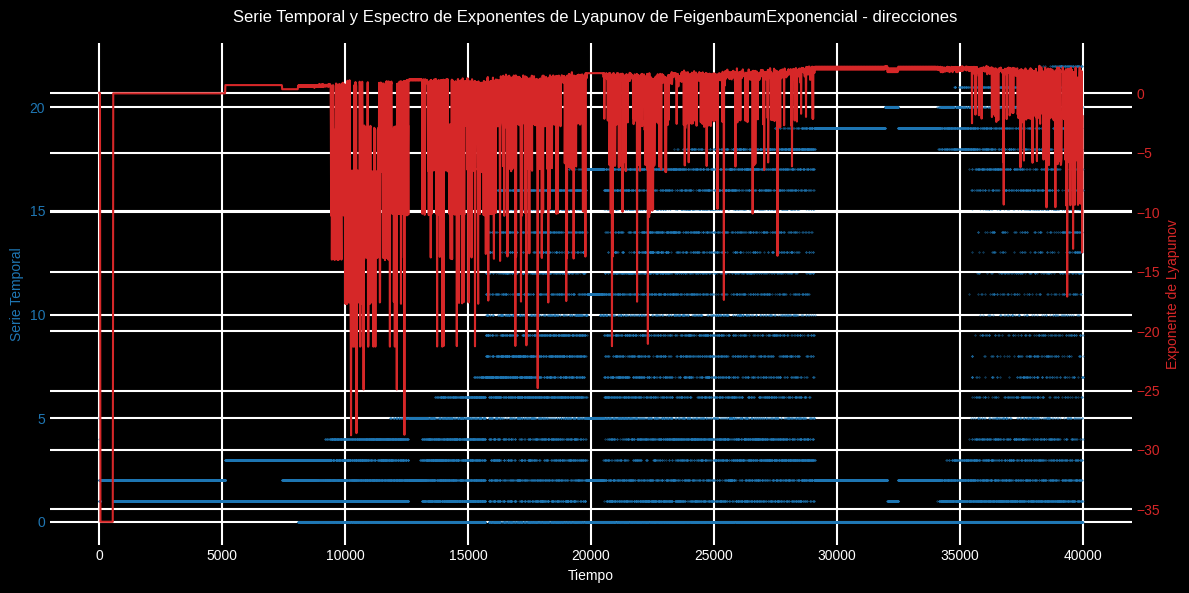

La dimension de Kaplan York es: 4.0332396702669016


In [18]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")


La gráfica muestra la evolución temporal de las direcciones seleccionadas por el caminante aleatorio, superpuesta con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Se observa una tendencia de las direcciones alrededor de valores específicos (mayores a 15), con un comportamiento más errático hacia el final de la serie.
- **Exponentes de Lyapunov**: Los exponentes de Lyapunov negativos indican estabilidad local y sensibilidad a las condiciones iniciales. La variabilidad en estos valores a lo largo del tiempo refleja la naturaleza caótica del sistema.
- **Dimensión de Kaplan Yorke**: 4.048835893117703. Este valor sugiere una complejidad en la dinámica del sistema, con una alta dimensión fractal que es típica en sistemas caóticos.


### Distancia

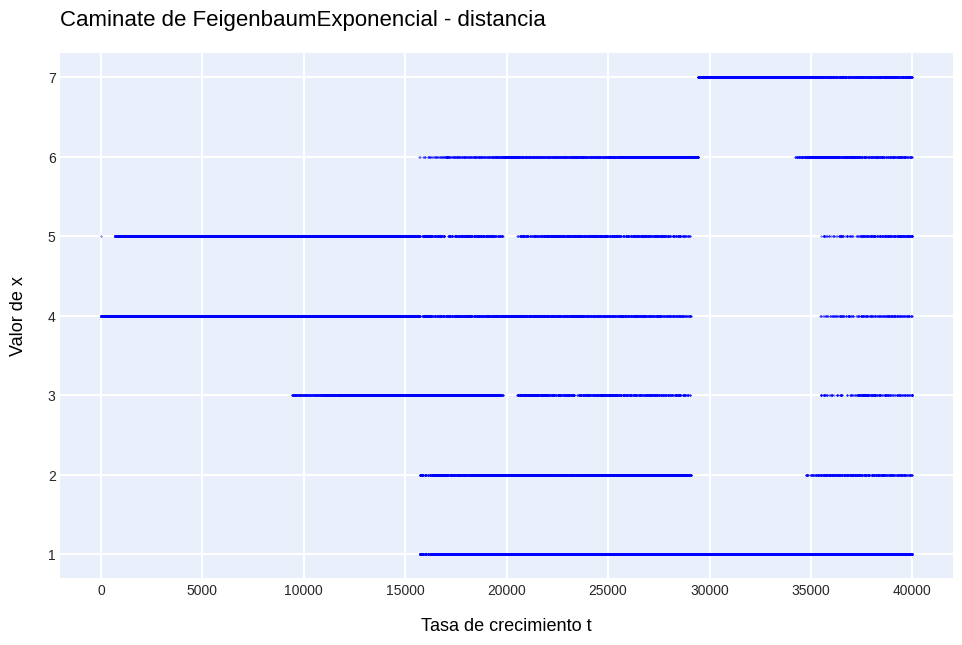

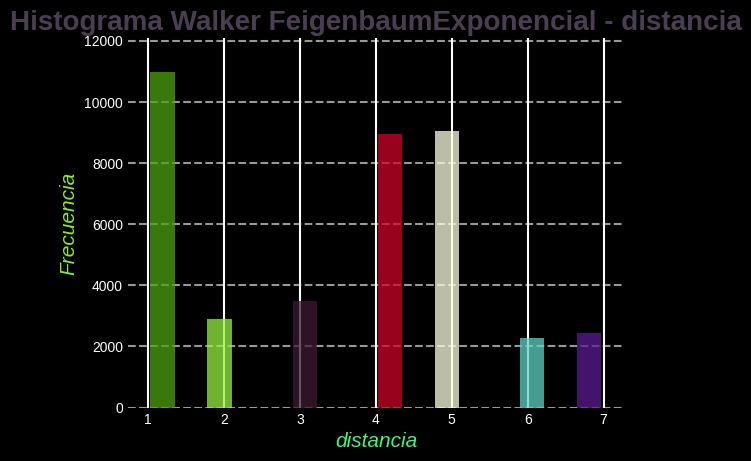

In [19]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

 Media (3.467): La media indica que, en promedio, el caminante avanza aproximadamente 3.467 unidades por movimiento.

 Mediana (4.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 4 y la otra mitad son mayores o iguales a 4.

 Moda (1, 10985): La moda muestra que la distancia de 1 unidad es la más frecuente, seleccionada 10,985 veces, lo que indica una fuerte preferencia por esta distancia.

 Desviación Estándar (1.887): La desviación estándar de 1.887 sugiere una variabilidad moderada en las distancias recorridas.

 Varianza (3.563): La varianza de 3.563 confirma la observación de la desviación estándar, indicando una dispersión moderada en las distancias recorridas.

 Asimetría (0.015): La asimetría cercana a 0 indica que la distribución de las distancias es bastante simétrica.

 Curtosis (1.141): La curtosis de 1.141 sugiere una distribución ligeramente más plana en comparación con una distribución normal, indicando menos valores extremos.

 Entropía (1.76): La entropía de 1.76 indica un nivel moderado de incertidumbre en la selección de distancias.

### Exponentes de Lyapounov y Kaplan Yorke

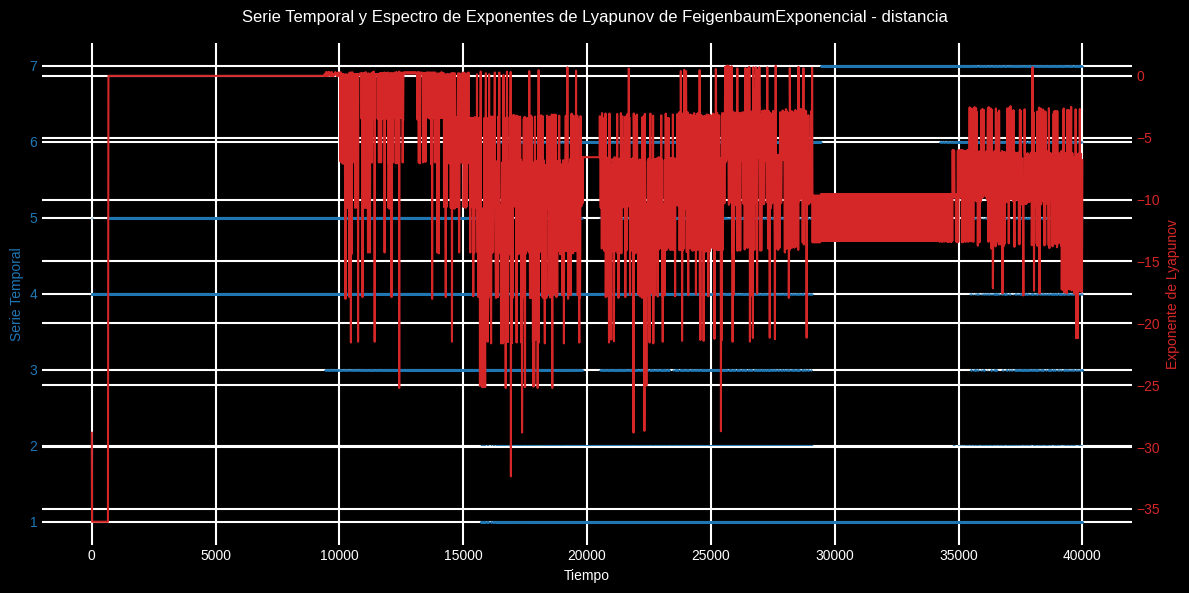

La dimension de Kaplan York es: 4.0


In [20]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

Esta gráfica ilustra la evolución de las distancias recorridas en cada paso por el caminante aleatorio, junto con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Las distancias se concentran en valores bajos (1 a 4), lo que sugiere que el caminante realiza pequeños desplazamientos con más frecuencia.
- **Exponentes de Lyapunov**: Al igual que en la gráfica de direcciones, los exponentes negativos predominan, indicando regiones de estabilidad y comportamiento caótico.
- **Dimensión de Kaplan Yorke**: 4.15538905224292. Este valor refuerza la idea de una dinámica compleja y caótica en el movimiento del caminante.


### Choques

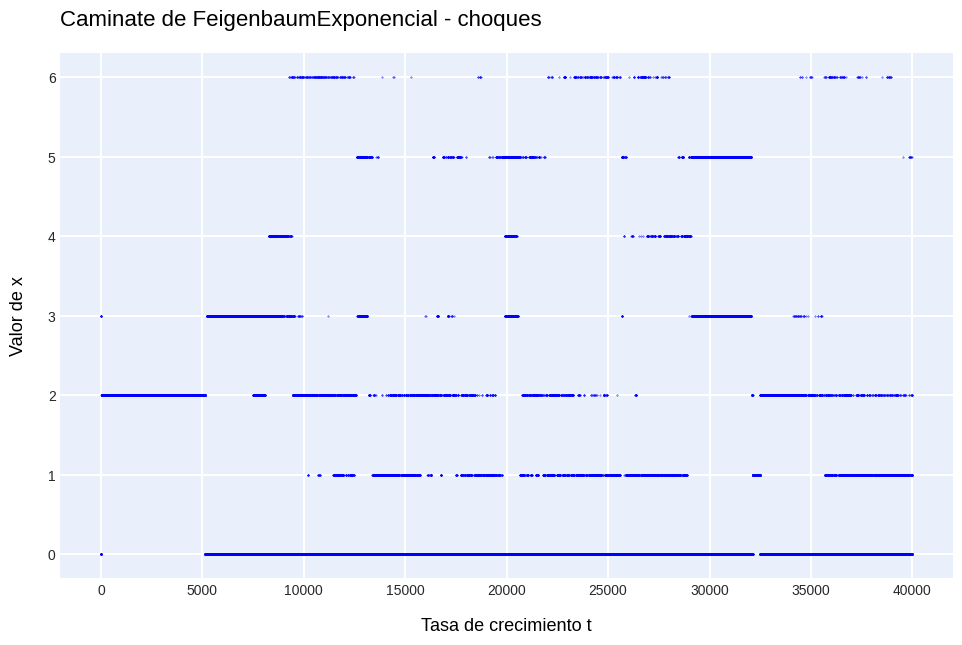

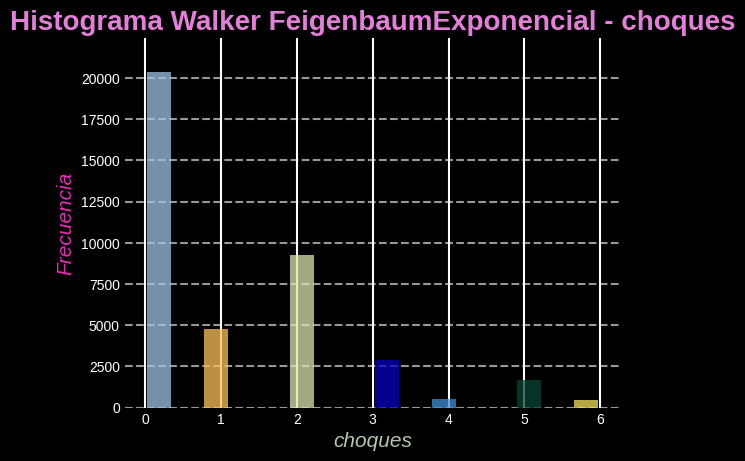

In [21]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

### Exponentes de lyapounov y Kaplan Yorke

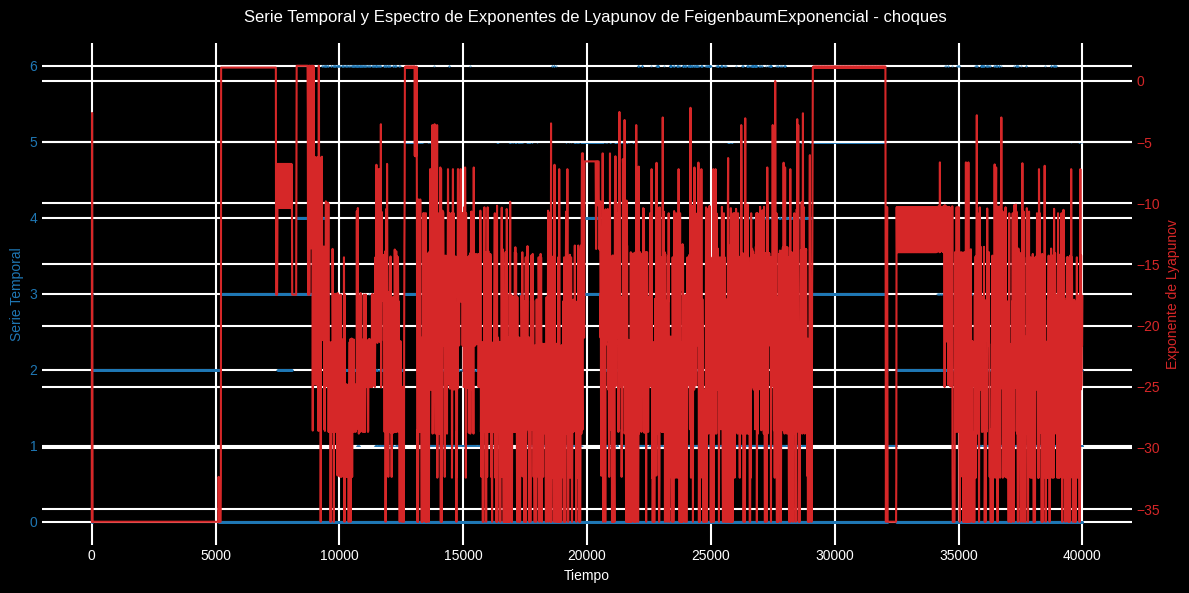

La dimension de Kaplan York es: 4.0


In [22]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

La gráfica muestra el comportamiento de los choques del caminante con las paredes del cubo, en combinación con los exponentes de Lyapunov.

- **Serie Temporal**: La mayoría de los datos indican choques con la pared etiquetada como '0' (sin choque), con algunos episodios de choques con otras paredes, especialmente hacia el final del tiempo.
- **Exponentes de Lyapunov**: Los exponentes negativos y su variabilidad reflejan el carácter caótico del sistema y su sensibilidad a las condiciones iniciales.
- **Dimensión de Kaplan Yorke**: Inf. Este resultado indica un nivel muy alto de complejidad y caos en el sistema, lo que podría estar relacionado con la alta frecuencia y variabilidad de los choques.


### Posiciones

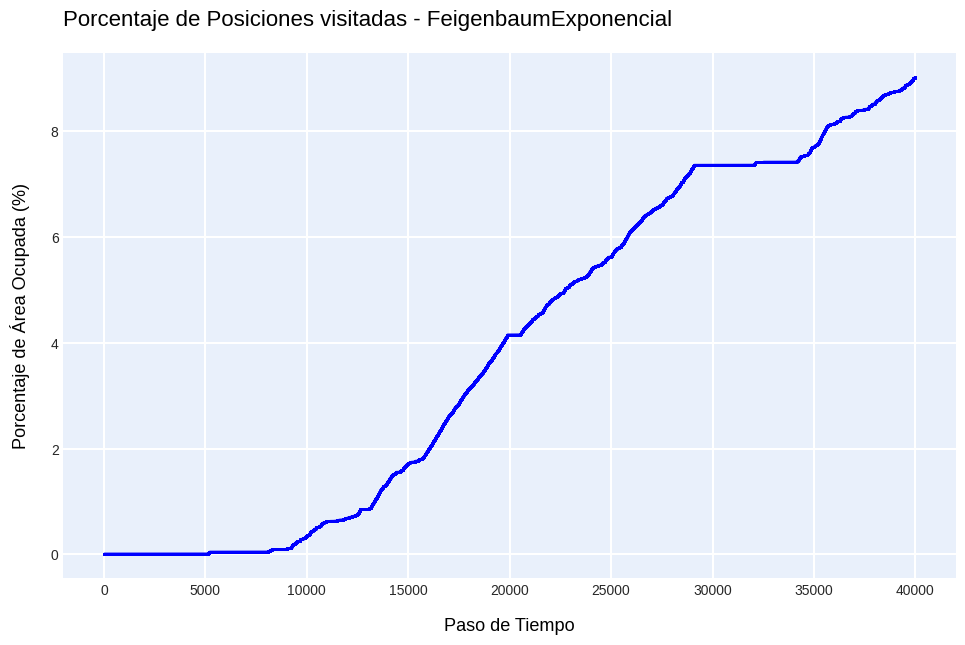

In [23]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

Media (33.164, 25.167, 27.957): La media indica que, en promedio, las posiciones visitadas por el caminante están alrededor de estos valores en el espacio tridimensional, con un sesgo hacia ciertas áreas del cubo.

Mediana (44.0, 24.0, 29.0): La mediana sugiere que la mitad de las posiciones visitadas se encuentran por debajo de estos valores, indicando una concentración en ciertas áreas del cubo.

Moda ([49, 49, 29], [14608, 10551, 9427]): La moda muestra que ciertas posiciones específicas son visitadas con mucha más frecuencia que otras, lo que indica una fuerte preferencia o patrón repetitivo en el movimiento del caminante.

Desviación Estándar (19.52, 21.569, 16.843): La desviación estándar indica una considerable variabilidad en las posiciones visitadas, especialmente en la segunda dimensión.

Varianza (381.046, 465.225, 283.703): La varianza confirma la alta dispersión en las posiciones visitadas, con una mayor dispersión en la segunda dimensión.

Asimetría (-0.808, 0.0, -0.4): La asimetría sugiere que la distribución de las posiciones visitadas tiene diferentes sesgos en cada dimensión, con una distribución más equilibrada en la segunda dimensión y distribuciones sesgadas hacia valores menores en las otras dos dimensiones.

Coeficiente de Variación (0.589, 0.857, 0.602): El coeficiente de variación indica que hay una relativa consistencia en la exploración a lo largo de las dimensiones, con la segunda dimensión mostrando más variabilidad relativa.

Curtosis (-1.097, -1.861, -1.053): La curtosis negativa indica que las posiciones visitadas tienen distribuciones más planas en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (2.684, 2.836, 2.953): La entropía indica un nivel moderado a alto de incertidumbre en la exploración de posiciones, lo que sugiere un balance entre aleatoriedad y repetición en el movimiento del caminante.


## Caminante de Feigenbaum Cúbico

![cubico](datos/FeigenbaumCubica/FeigenbaumCubica2.png)


### Direccion

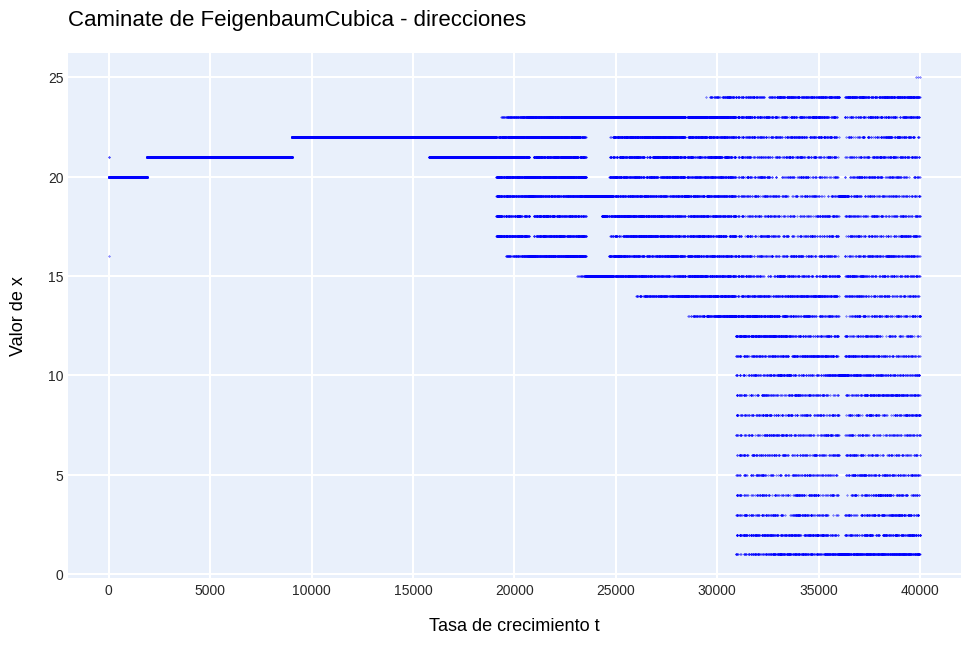

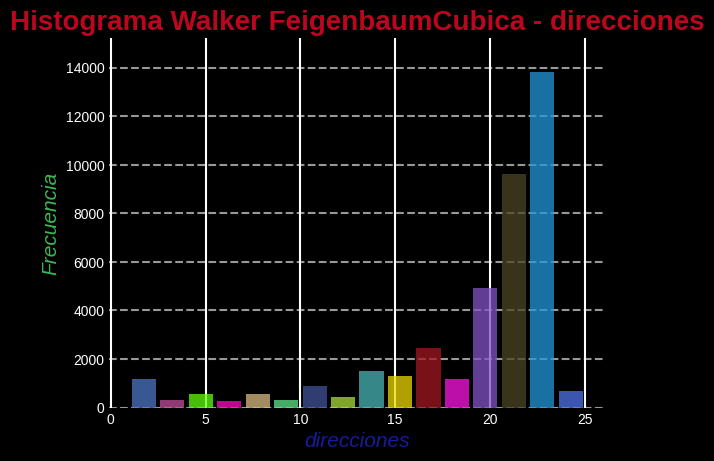

In [24]:
modelo = "feigenbaumcubica"
metrica = "direcciones"
folder = "FeigenbaumCubica"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (18.791): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 18.791.

Mediana (21.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 21 y la otra mitad son mayores o iguales a 21.

Moda (22, 11134): La moda muestra que la dirección 22 es la más frecuente, seleccionada 11,134 veces, lo que indica una fuerte preferencia del caminante por moverse en esta dirección.

Desviación Estándar (5.212): La desviación estándar de 5.212 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

Varianza (27.16): La varianza de 27.16 confirma una alta dispersión en las direcciones seleccionadas.

Asimetría (-1.944): La asimetría de -1.944 sugiere que la distribución está sesgada hacia la izquierda, indicando una cola más larga en el lado izquierdo de la distribución.

Curtosis (3.133): La curtosis de 3.133 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (2.384): La entropía de 2.384 indica un nivel moderado de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.


### Exponentes de lyapounov y Kaplan Yorke

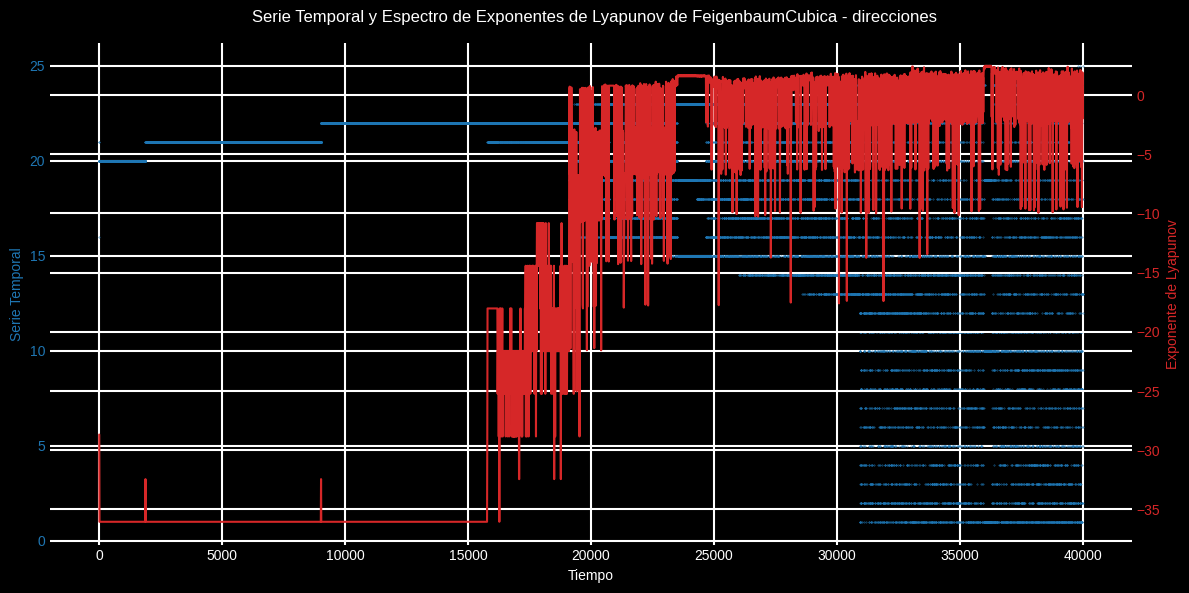

La dimension de Kaplan York es: 4.0


In [25]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Distancia

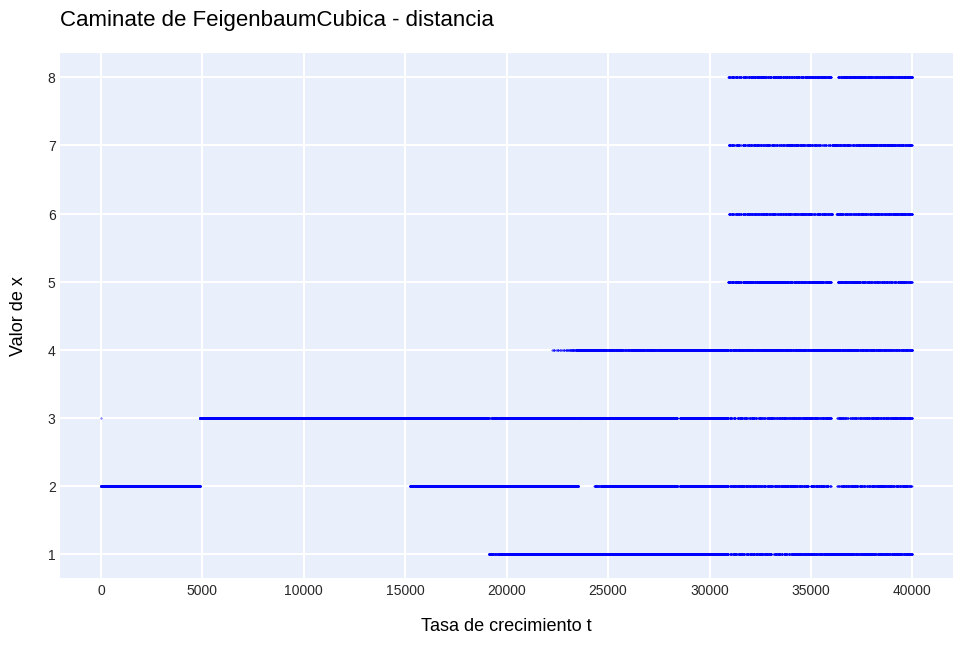

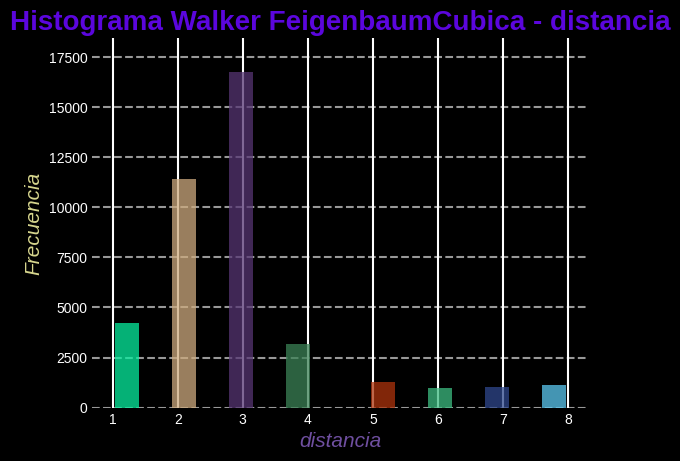

Métrica       Valor
0                      Media       2.965
1                    Mediana         3.0
2                       Moda  (3, 16780)
3           Media Geométrica       2.646
4                      Rango           7
5        Desviación Estándar       1.498
6                   Varianza       2.245
7                  Asimetría       1.565
8   Coeficiente de Variación       0.505
9                   Curtosis       2.838
10                  Entropía       1.556
11              Percentil 25         2.0
12              Percentil 50         3.0
13              Percentil 75         3.0
14                 Cuartil 1         2.0
15                 Cuartil 2         3.0
16                 Cuartil 3         3.0

In [26]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])
res

#### Interpretación de las Métricas

Media (2.965): La media indica que, en promedio, el caminante avanza aproximadamente 2.965 unidades por movimiento.

Mediana (3.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 3 y la otra mitad son mayores o iguales a 3.

Moda (3, 16780): La moda muestra que la distancia de 3 unidades es la más frecuente, seleccionada 16,780 veces, lo que indica una fuerte preferencia por esta distancia.

Desviación Estándar (1.498): La desviación estándar de 1.498 sugiere una variabilidad moderada en las distancias recorridas.

Varianza (2.245): La varianza de 2.245 confirma la observación de la desviación estándar, indicando una dispersión moderada en las distancias recorridas.

Asimetría (1.565): La asimetría de 1.565 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (2.838): La curtosis de 2.838 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (1.556): La entropía de 1.556 indica un nivel moderado de incertidumbre en la selección de distancias.


### Exponentes de lyapounov y Kaplan Yorke

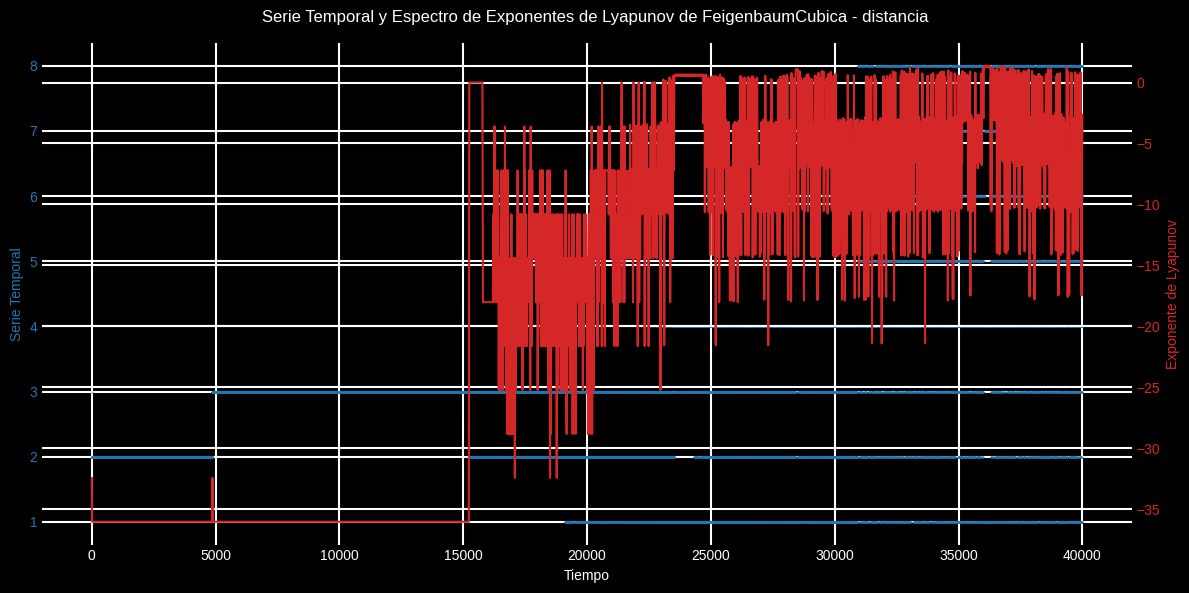

La dimension de Kaplan York es: 4.0


In [27]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Choques

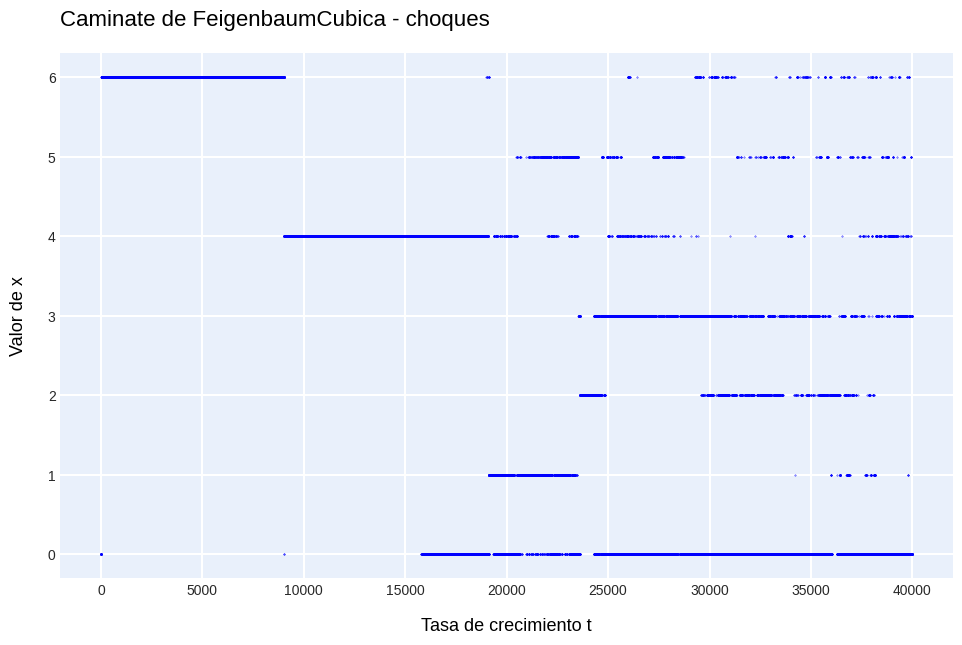

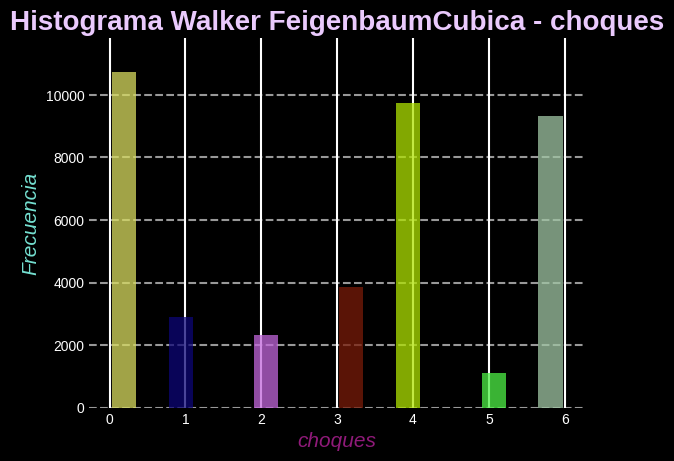

In [28]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

### Exponentes de lyapounov y Kaplan Yorke

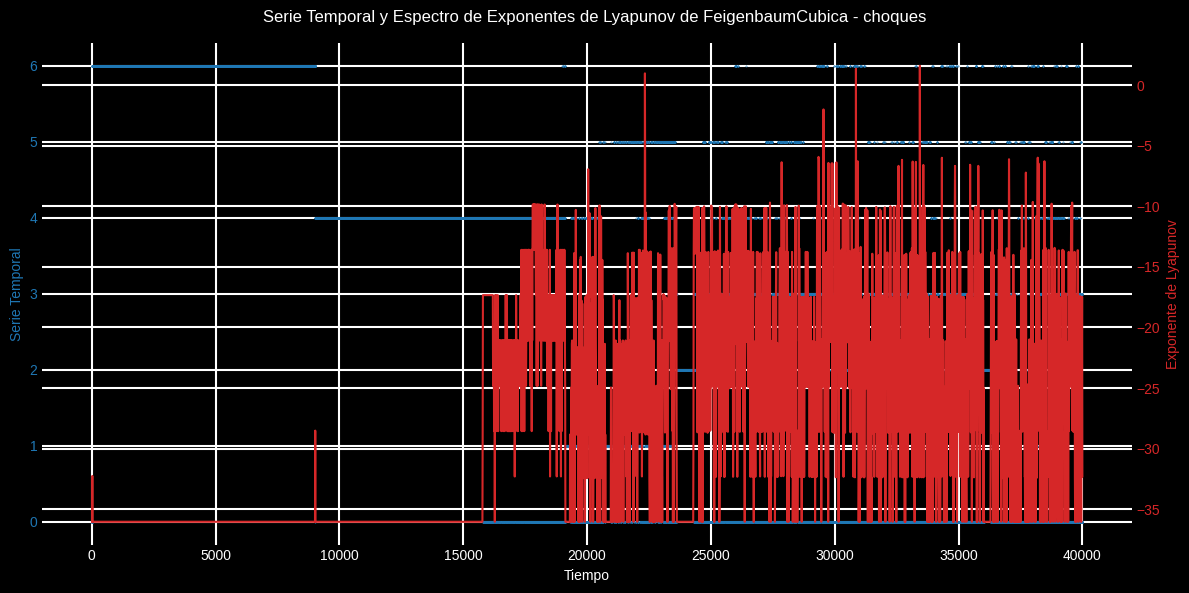

La dimension de Kaplan York es: 5.014936228212478


In [29]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Posiciones

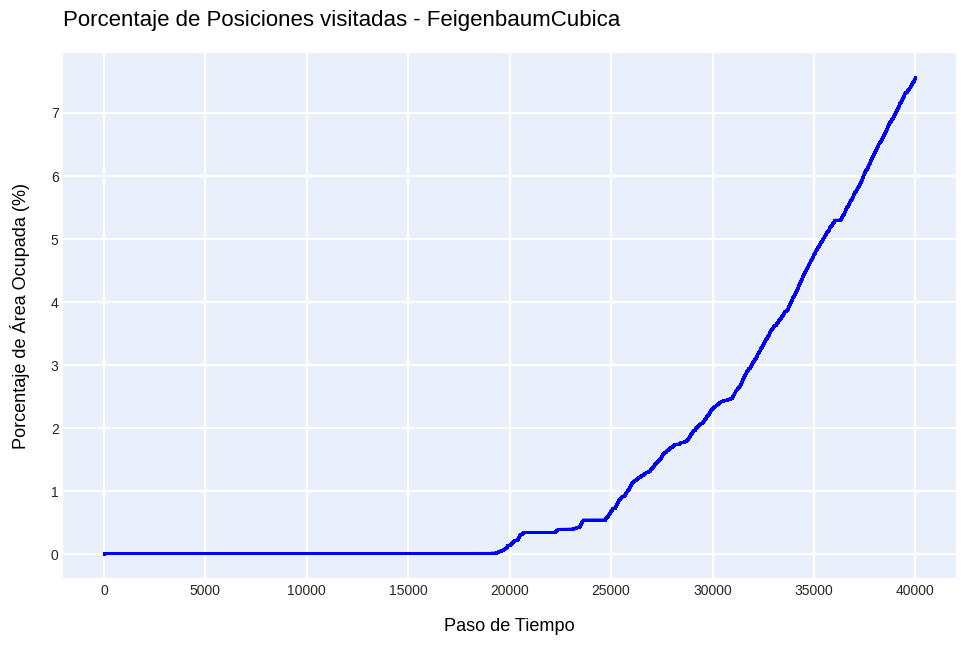

In [30]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

Media (12.535, 20.445, 31.584): La media indica que, en promedio, las posiciones visitadas por el caminante están alrededor de estos valores en el espacio tridimensional, con un sesgo hacia ciertas áreas del cubo.

Mediana (6.0, 10.0, 43.0): La mediana sugiere que la mitad de las posiciones visitadas se encuentran por debajo de estos valores, indicando una concentración en ciertas áreas del cubo.

Moda ([0, 4, 49], [12610, 9435, 10182]): La moda muestra que ciertas posiciones específicas son visitadas con mucha más frecuencia que otras, lo que indica una fuerte preferencia o patrón repetitivo en el movimiento del caminante.

Desviación Estándar (17.186, 19.149, 18.739): La desviación estándar indica una considerable variabilidad en las posiciones visitadas, especialmente en la primera y segunda dimensiones.

Varianza (295.373, 366.701, 351.154): La varianza confirma la alta dispersión en las posiciones visitadas, con una mayor dispersión en la segunda dimensión.

Asimetría (1.266, 0.548, -0.687): La asimetría sugiere que la distribución de las posiciones visitadas tiene diferentes sesgos en cada dimensión, con una distribución más equilibrada en la segunda dimensión y distribuciones sesgadas hacia valores mayores en las otras dos dimensiones.

Coeficiente de Variación (1.371, 0.937, 0.593): El coeficiente de variación indica que hay una relativa consistencia en la exploración a lo largo de las dimensiones, con la primera dimensión mostrando más variabilidad relativa.

Curtosis (-0.068, -1.495, -1.235): La curtosis negativa indica que las posiciones visitadas tienen distribuciones más planas en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (2.569, 2.561, 2.819): La entropía indica un nivel moderado a alto de incertidumbre en la exploración de posiciones, lo que sugiere un balance entre aleatoriedad y repetición en el movimiento del caminante.


### Interpretación de las Métricas de Caos para Feigenbaum Cúbico

#### Serie Temporal y Espectro de Exponentes de Lyapunov - Direcciones

La gráfica muestra la evolución temporal de las direcciones seleccionadas por el caminante aleatorio, superpuesta con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Se observa una tendencia de las direcciones alrededor de valores específicos (mayores a 15), con un comportamiento más errático hacia el final de la serie.
- **Exponentes de Lyapunov**: Los exponentes de Lyapunov negativos indican estabilidad local y sensibilidad a las condiciones iniciales. La variabilidad en estos valores a lo largo del tiempo refleja la naturaleza caótica del sistema.
- **Dimensión de Kaplan Yorke**: 4.0. Este valor sugiere una complejidad en la dinámica del sistema, con una alta dimensión fractal que es típica en sistemas caóticos.

---

#### Serie Temporal y Espectro de Exponentes de Lyapunov - Distancia

Esta gráfica ilustra la evolución de las distancias recorridas en cada paso por el caminante aleatorio, junto con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Las distancias se concentran en valores bajos (1 a 4), lo que sugiere que el caminante realiza pequeños desplazamientos con más frecuencia.
- **Exponentes de Lyapunov**: Al igual que en la gráfica de direcciones, los exponentes negativos predominan, indicando regiones de estabilidad y comportamiento caótico.
- **Dimensión de Kaplan Yorke**: 4.0. Este valor refuerza la idea de una dinámica compleja y caótica en el movimiento del caminante.

---

#### Serie Temporal y Espectro de Exponentes de Lyapunov - Choques

La gráfica muestra el comportamiento de los choques del caminante con las paredes del cubo, en combinación con los exponentes de Lyapunov.

- **Serie Temporal**: La mayoría de los datos indican choques con la pared etiquetada como '0' (sin choque), con algunos episodios de choques con otras paredes, especialmente hacia el final del tiempo.
- **Exponentes de Lyapunov**: Los exponentes negativos y su variabilidad reflejan el carácter caótico del sistema y su sensibilidad a las condiciones iniciales.
- **Dimensión de Kaplan Yorke**: 4.0. Este resultado indica un nivel muy alto de complejidad y caos en el sistema, lo que podría estar relacionado con la alta frecuencia y variabilidad de los choques.

Estas métricas y gráficas confirman que el comportamiento del caminante aleatorio, alimentado por modelos caóticos, exhibe las características típicas de sistemas caóticos: sensibilidad a las condiciones iniciales, comportamiento impredecible y una estructura fractal compleja.


## Caminante de Feigenbaum Triangular

![triangular](datos/FeigenbaumTriangular/FeigenbaumTriangular2.png)


### Dirección

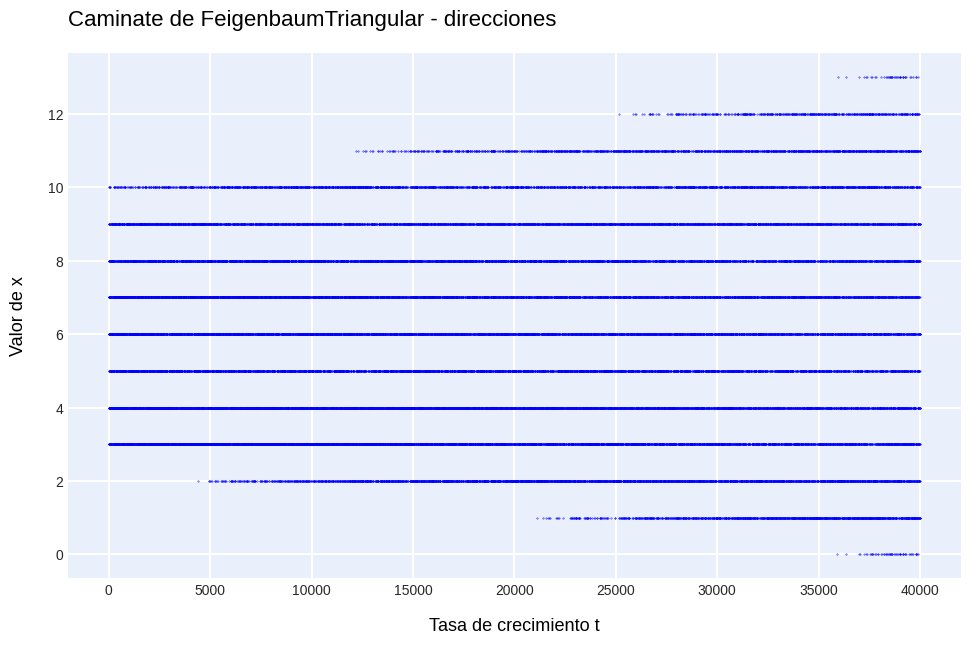

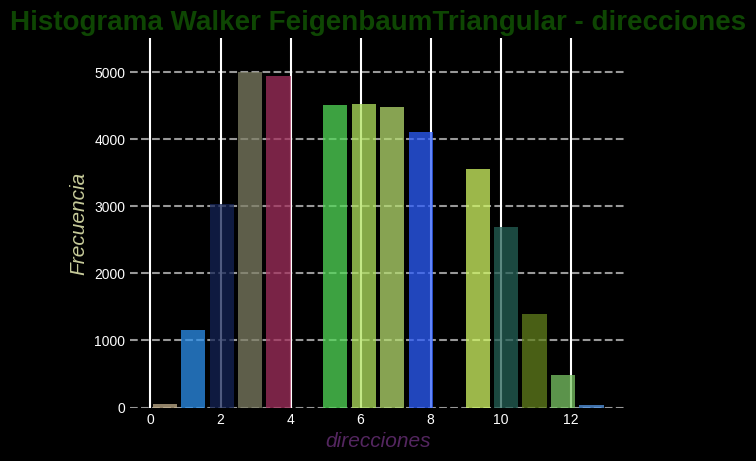

In [31]:
modelo = "feigenbaumtriangular"
metrica = "direcciones"
folder = "FeigenbaumTriangular"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (5.918): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 5.918.

Mediana (6.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 6 y la otra mitad son mayores o iguales a 6.

Moda (3, 5008): La moda muestra que la dirección 3 es la más frecuente, seleccionada 5,008 veces, lo que indica una fuerte preferencia del caminante por moverse en esta dirección.

Desviación Estándar (2.736): La desviación estándar de 2.736 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

Varianza (7.483): La varianza de 7.483 confirma una alta dispersión en las direcciones seleccionadas.

Asimetría (0.177): La asimetría cercana a 0 sugiere que la distribución de las direcciones es bastante simétrica.

Curtosis (-0.875): La curtosis de -0.875 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (2.373): La entropía de 2.373 indica un nivel moderado de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.


### EXPONENTES DE LYAPOUNOV Y KAPLAN YORKE

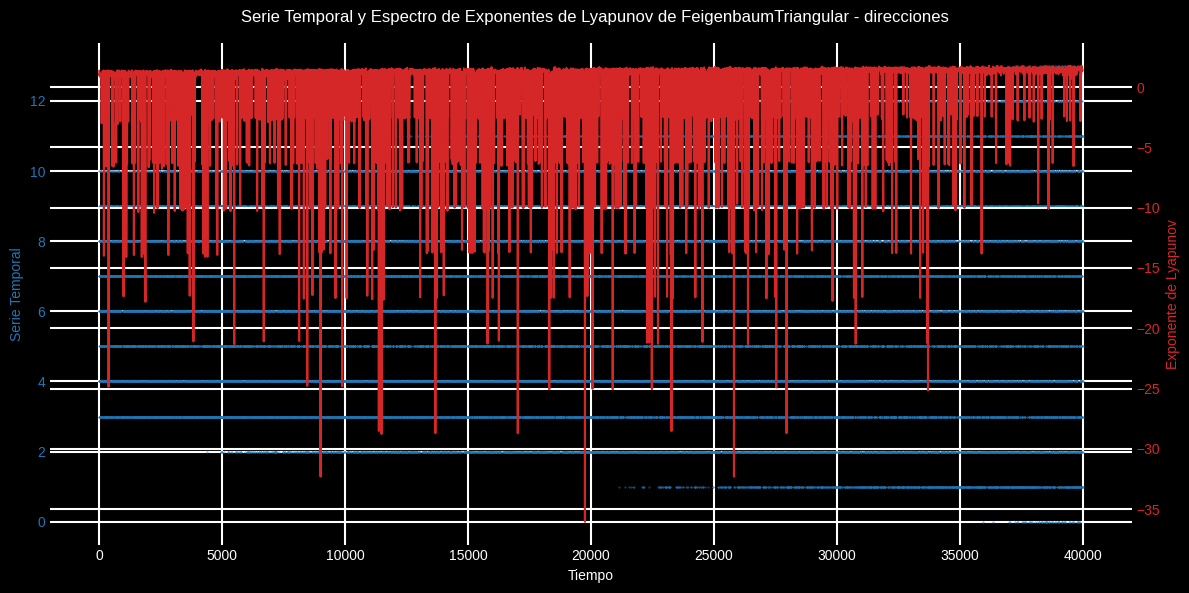

La dimension de Kaplan York es: 4.002957255766532


In [32]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Distancia

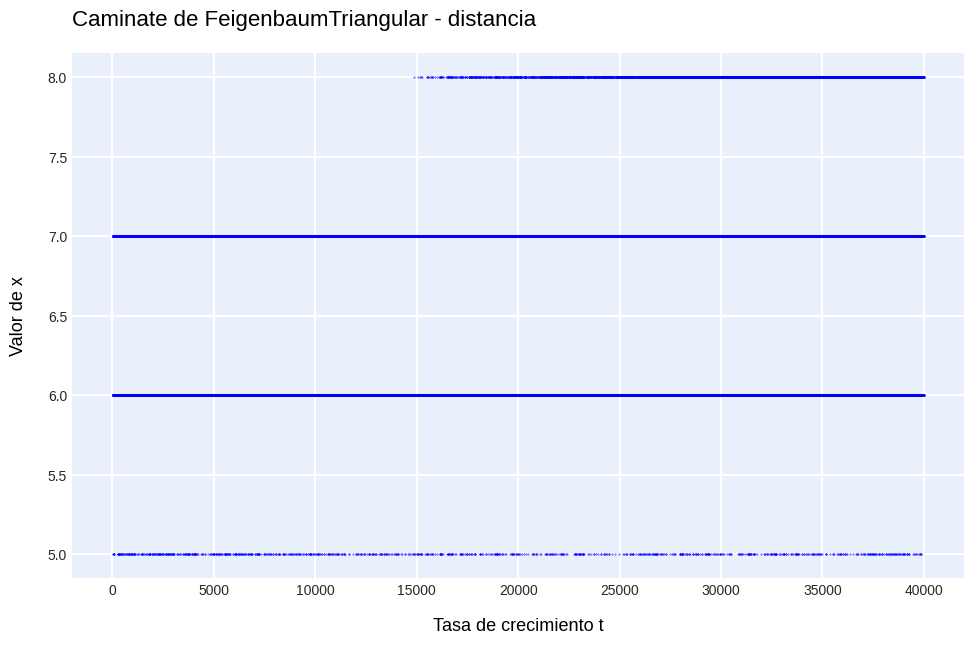

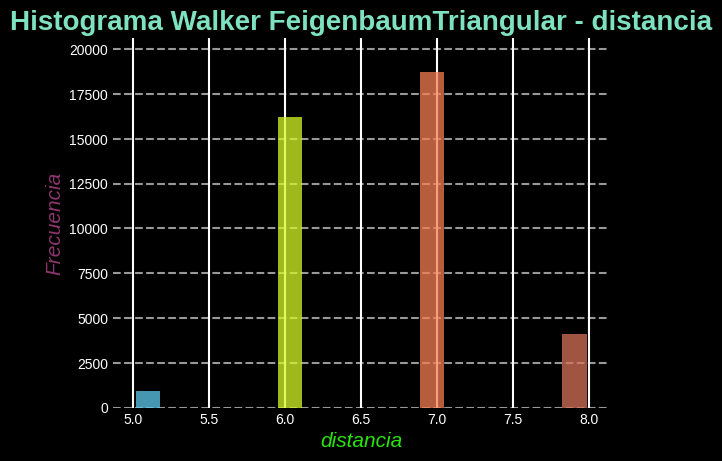

In [33]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (6.65): La media indica que, en promedio, el caminante avanza aproximadamente 6.65 unidades por movimiento.

Mediana (7.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 7 y la otra mitad son mayores o iguales a 7.

Moda (7, 18754): La moda muestra que la distancia de 7 unidades es la más frecuente, seleccionada 18,754 veces, lo que indica una fuerte preferencia por esta distancia.

Desviación Estándar (0.692): La desviación estándar de 0.692 sugiere una baja variabilidad en las distancias recorridas.

Varianza (0.478): La varianza de 0.478 confirma la observación de la desviación estándar, indicando una baja dispersión en las distancias recorridas.

Asimetría (0.169): La asimetría cercana a 0 indica que la distribución de las distancias es bastante simétrica.

Curtosis (-0.418): La curtosis de -0.418 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (1.042): La entropía de 1.042 indica un nivel bajo de incertidumbre en la selección de distancias.


### Exponentes de lyapounov y Kaplan Yorke

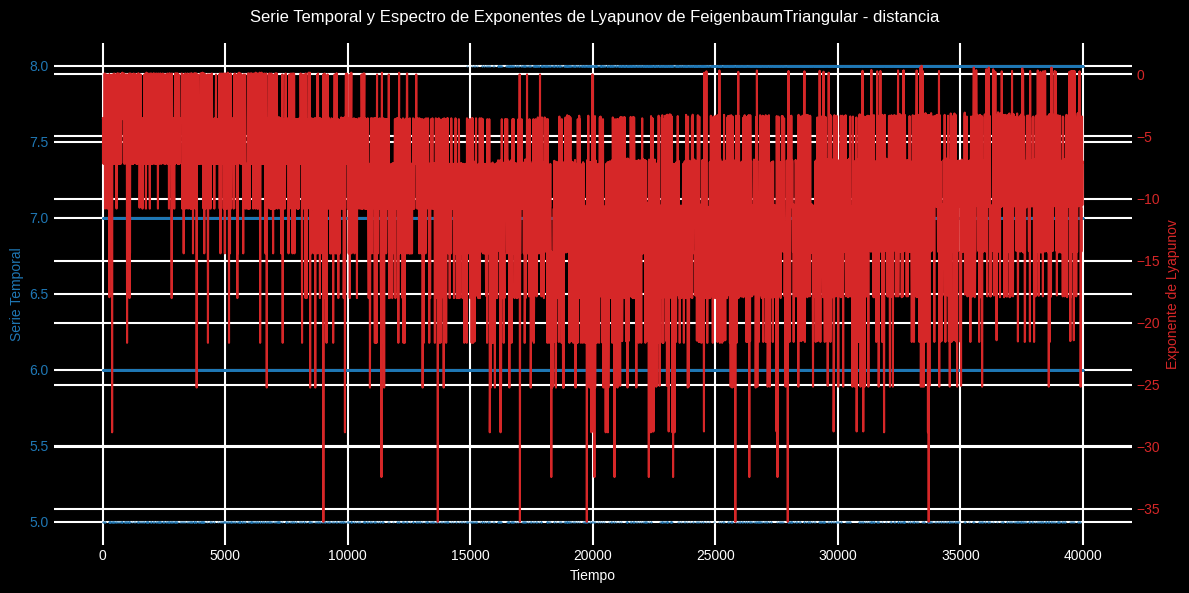

La dimension de Kaplan York es: 4.25


In [34]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Choques

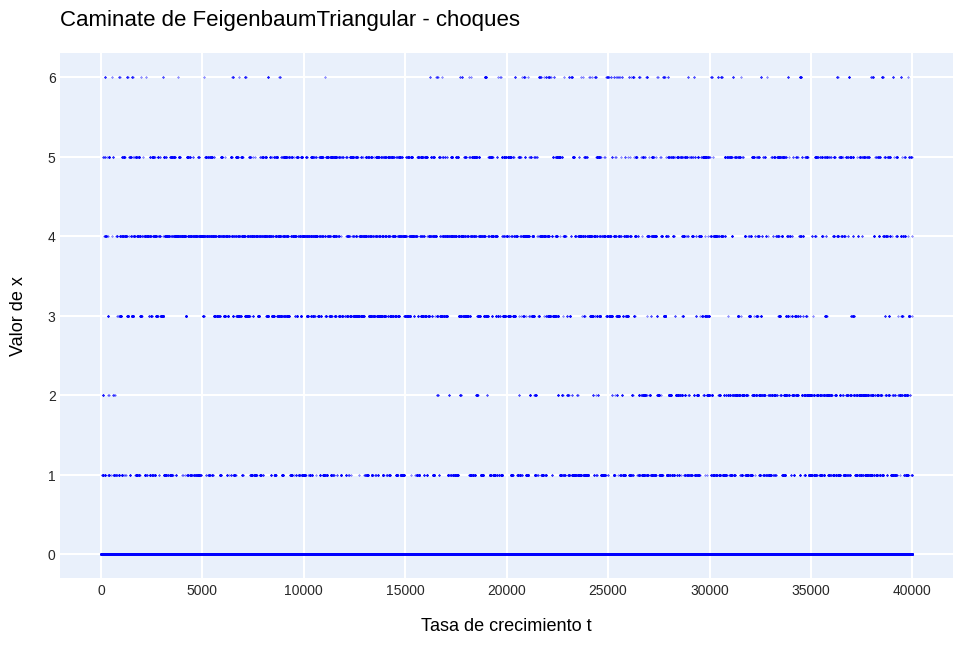

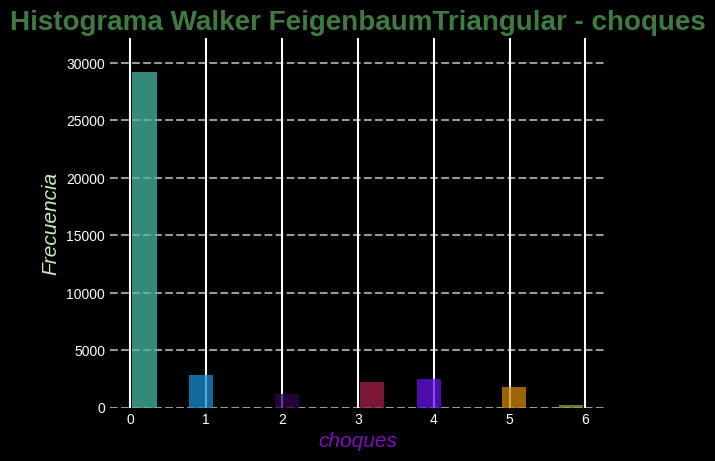

In [35]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

### Posiciones

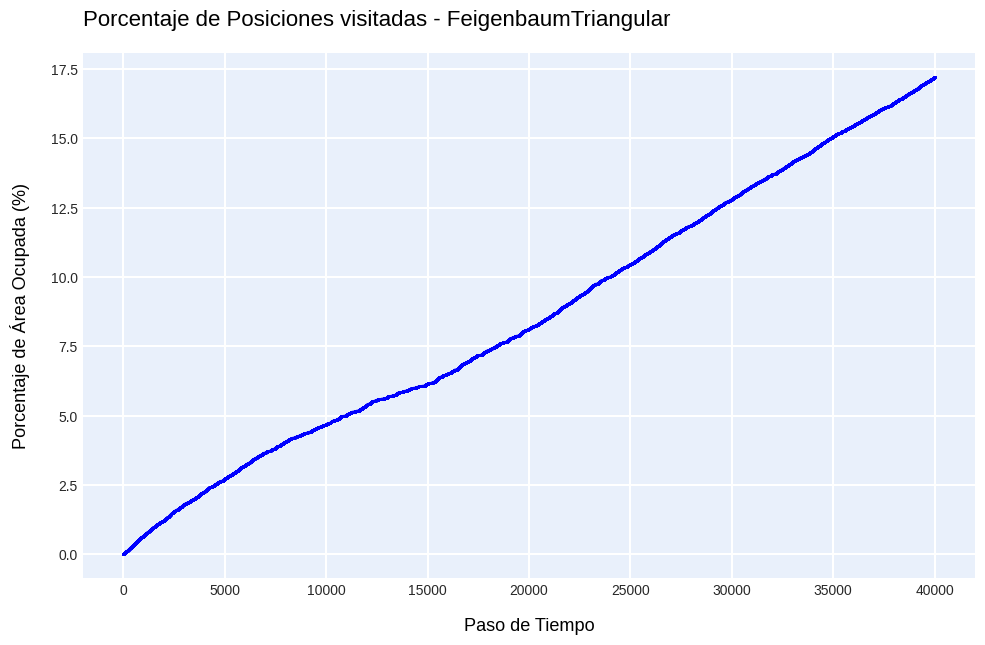

In [36]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

Media (0.805): La media indica que, en promedio, el caminante choca con las paredes del cubo aproximadamente 0.805 veces por movimiento.

Mediana (0.0): La mediana sugiere que la mitad de los movimientos no resultan en choques.

Moda (0, 29257): La moda muestra que no chocar es el evento más frecuente, ocurriendo 29,257 veces.

Desviación Estándar (1.539): La desviación estándar de 1.539 sugiere una variabilidad considerable en el número de choques.

Varianza (2.367): La varianza de 2.367 confirma una alta dispersión en el número de choques.

Asimetría (1.756): La asimetría de 1.756 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (1.669): La curtosis de 1.669 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (1.022): La entropía de 1.022 indica un nivel bajo de incertidumbre en la ocurrencia de choques.


### Serie Temporal y Espectro de Exponentes de Lyapunov - FeigenbaumTriangular (direcciones)

La gráfica muestra la evolución temporal de las direcciones seleccionadas por el caminante aleatorio, superpuesta con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Las direcciones se concentran en un rango amplio (de 0 a más de 10), lo que indica una mayor diversidad en las direcciones tomadas por el caminante. Hay episodios de alta variabilidad a lo largo del tiempo.
- **Exponentes de Lyapunov**: Los exponentes de Lyapunov negativos predominan, lo que sugiere que el sistema es localmente estable en muchas regiones, pero con una sensibilidad a las condiciones iniciales que induce comportamiento caótico.
- **Dimensión de Kaplan Yorke**: 4.002957255766532. Este valor indica una complejidad moderada en la dinámica del sistema, con una estructura fractal típica de sistemas caóticos.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - FeigenbaumTriangular (distancia)

Esta gráfica ilustra la evolución de las distancias recorridas en cada paso por el caminante aleatorio, junto con el espectro de exponentes de Lyapunov.

- **Serie Temporal**: Las distancias se concentran principalmente en valores bajos (alrededor de 5 a 8), lo que sugiere que el caminante realiza desplazamientos pequeños y medianos con más frecuencia.
- **Exponentes de Lyapunov**: Al igual que en la gráfica de direcciones, los exponentes de Lyapunov negativos predominan, lo que indica regiones de estabilidad local y comportamiento caótico.
- **Dimensión de Kaplan Yorke**: 4.25. Este valor refuerza la idea de una dinámica compleja y caótica en el movimiento del caminante, con una estructura fractal.

---


## Atractor de Henón

![henon](datos/Henon/Henon2.png)


### Direcciones

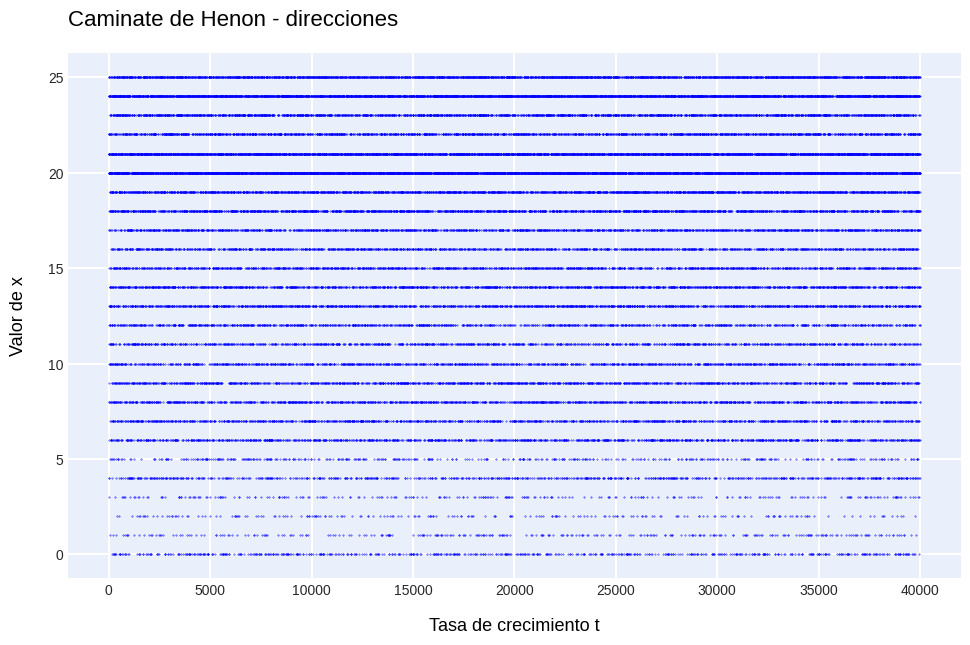

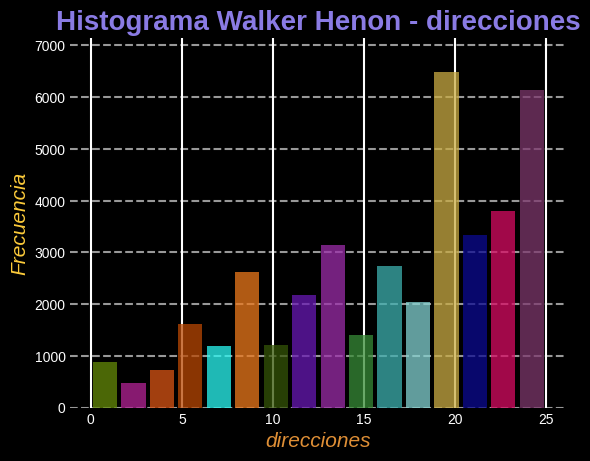

In [37]:
modelo = "transfhenon"
metrica = "direcciones"
folder = "Henon"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (16.507): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 16.507.

Mediana (18.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 18 y la otra mitad son mayores o iguales a 18.

Moda (20, 4333): La moda muestra que la dirección 20 es la más frecuente, seleccionada 4,333 veces, lo que indica una fuerte preferencia del caminante por moverse en esta dirección.

Desviación Estándar (6.525): La desviación estándar de 6.525 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

Varianza (42.58): La varianza de 42.58 confirma una alta dispersión en las direcciones seleccionadas.

Asimetría (-0.644): La asimetría de -0.644 sugiere que la distribución está sesgada hacia la izquierda, indicando una cola más larga en el lado izquierdo de la distribución.

Curtosis (-0.583): La curtosis de -0.583 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (3.056): La entropía de 3.056 indica un alto nivel de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.


### Exponentes de lyapounov y Kaplan Yorke

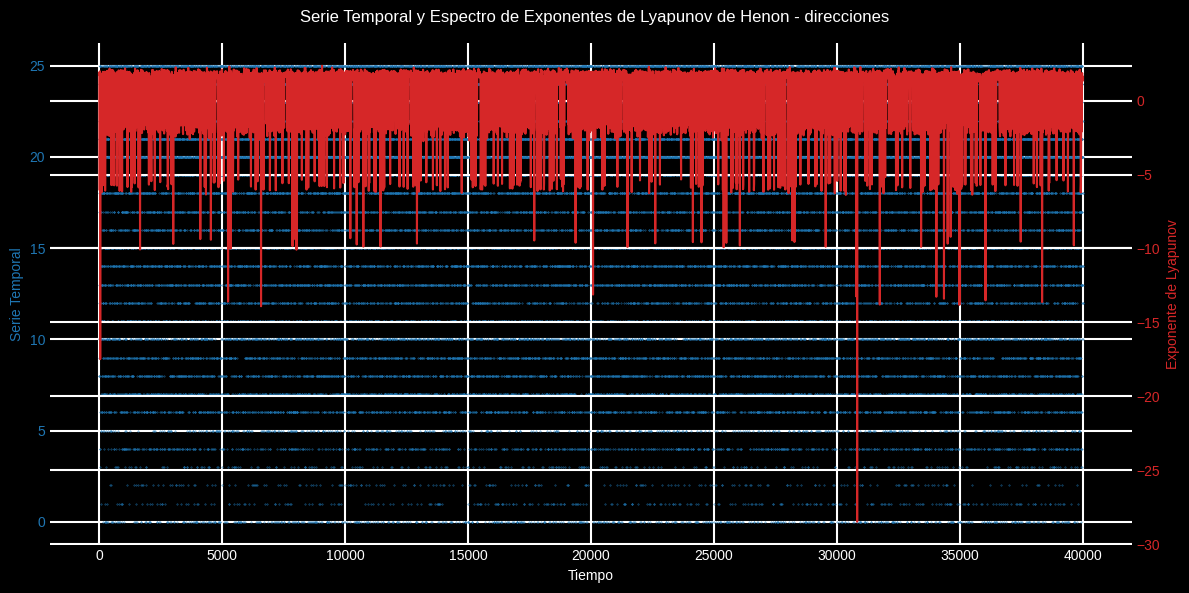

La dimension de Kaplan York es: 4.033920214989325


In [38]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Distancias

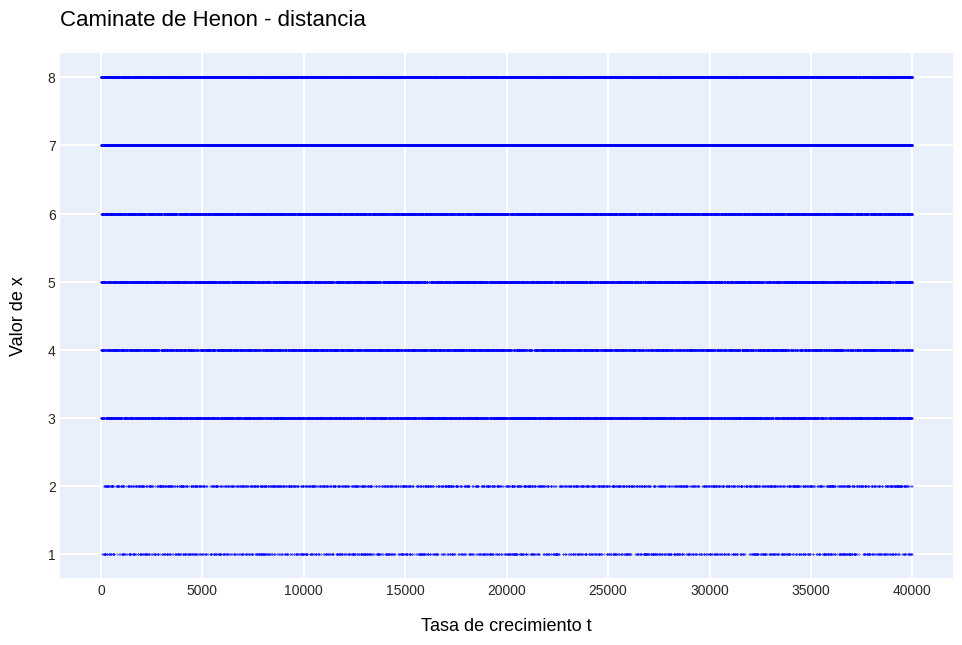

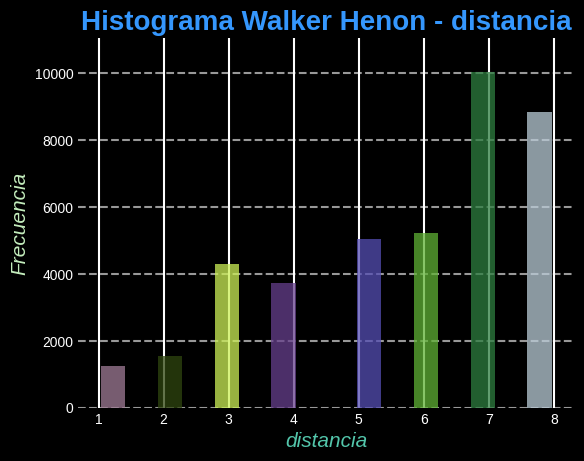

In [39]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (5.747): La media indica que, en promedio, el caminante avanza aproximadamente 5.747 unidades por movimiento.

Mediana (6.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 6 y la otra mitad son mayores o iguales a 6.

Moda (7, 10052): La moda muestra que la distancia de 7 unidades es la más frecuente, seleccionada 10,052 veces, lo que indica una fuerte preferencia por esta distancia.

Desviación Estándar (1.985): La desviación estándar de 1.985 sugiere una variabilidad moderada en las distancias recorridas.

Varianza (3.94): La varianza de 3.94 confirma la observación de la desviación estándar, indicando una dispersión moderada en las distancias recorridas.

Asimetría (-0.656): La asimetría de -0.656 sugiere que la distribución está sesgada hacia la izquierda, indicando una cola más larga en el lado izquierdo de la distribución.

Curtosis (-0.628): La curtosis de -0.628 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (1.903): La entropía de 1.903 indica un nivel moderado de incertidumbre en la selección de distancias.


### Exponentes de lyapounov y Kaplan Yorke

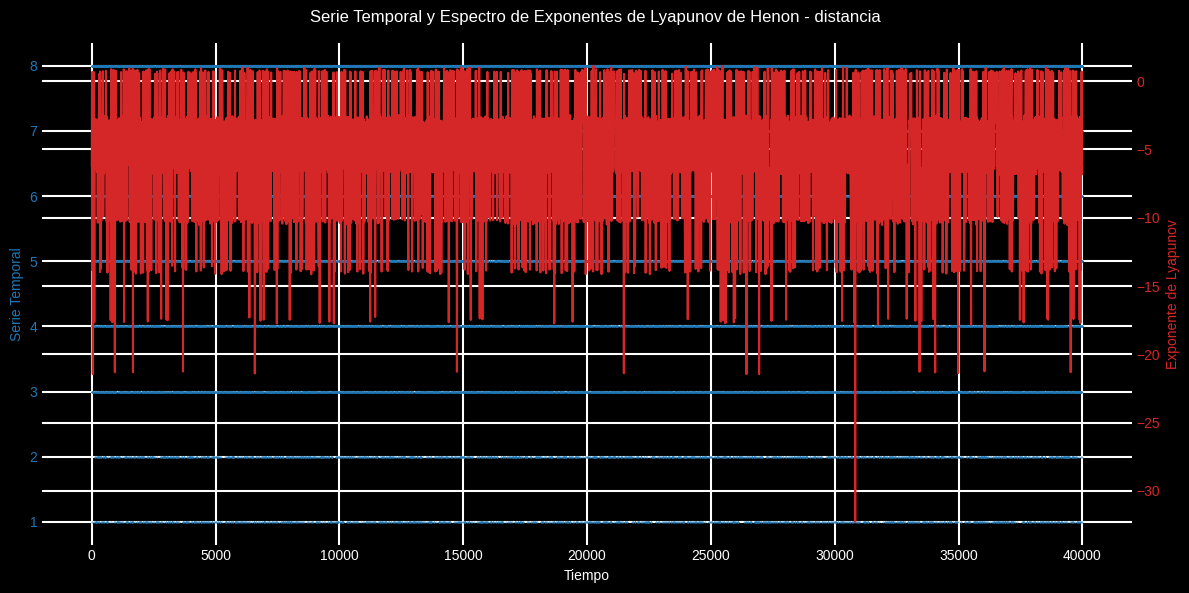

La dimension de Kaplan York es: 4.138906299937377


In [40]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Choques

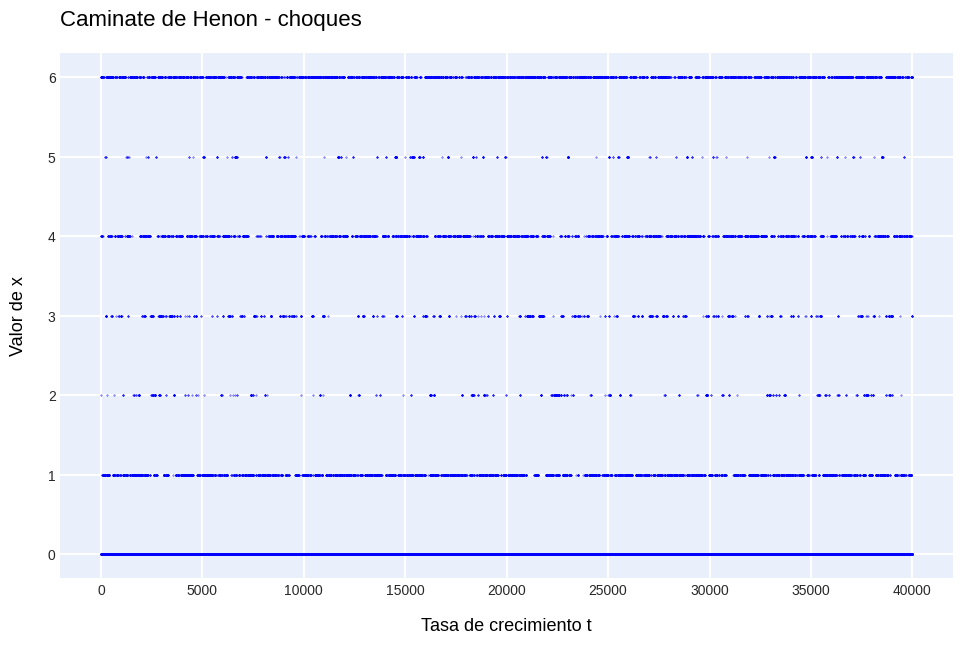

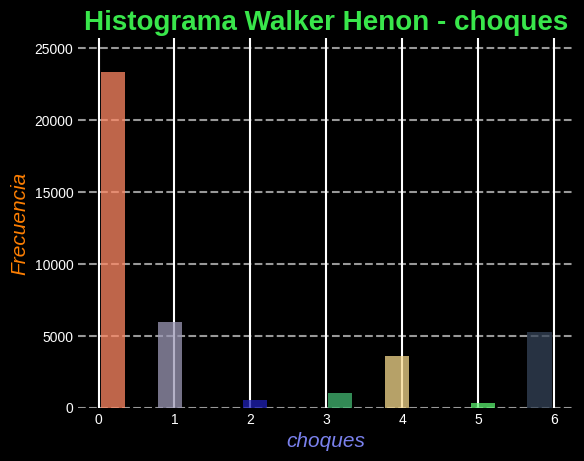

In [41]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (1.44): La media indica que, en promedio, el caminante choca con las paredes del cubo aproximadamente 1.44 veces por movimiento.

Mediana (0.0): La mediana sugiere que la mitad de los movimientos no resultan en choques.

Moda (0, 23362): La moda muestra que no chocar es el evento más frecuente, ocurriendo 23,362 veces.

Desviación Estándar (2.178): La desviación estándar de 2.178 sugiere una variabilidad considerable en el número de choques.

Varianza (4.745): La varianza de 4.745 confirma una alta dispersión en el número de choques.

Asimetría (1.233): La asimetría de 1.233 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (-0.113): La curtosis de -0.113 indica que la distribución es más plana en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (1.267): La entropía de 1.267 indica un nivel moderado de incertidumbre en la ocurrencia de choques.


### Exponentes de lyapounov y Kaplan Yorke

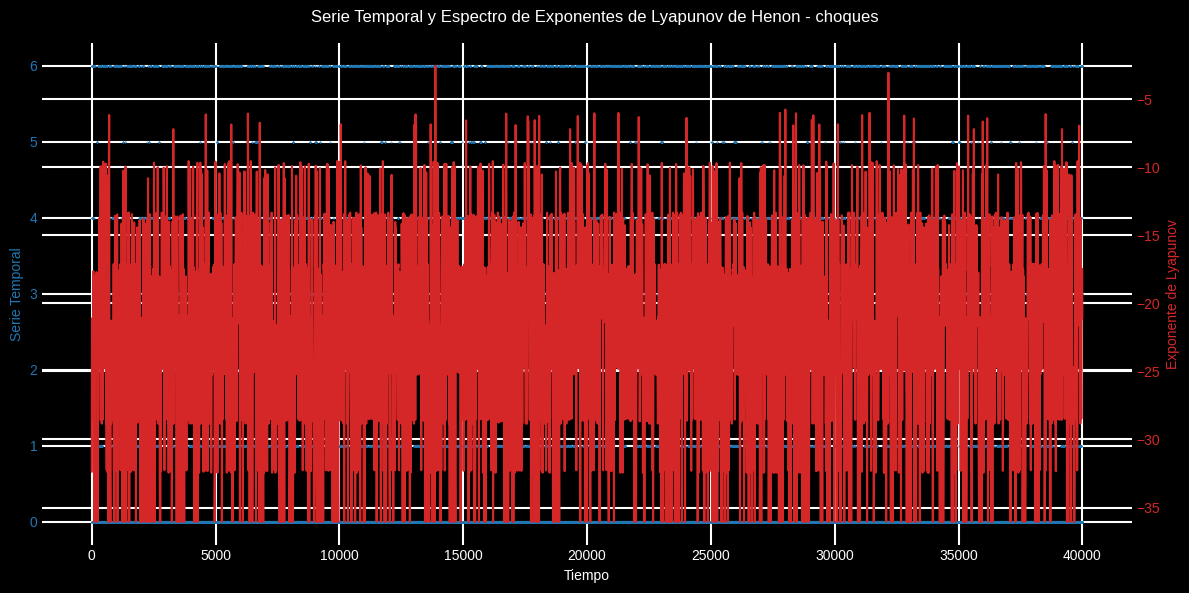

La dimension de Kaplan York es: 1.0260431731713948


In [42]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Posiciones

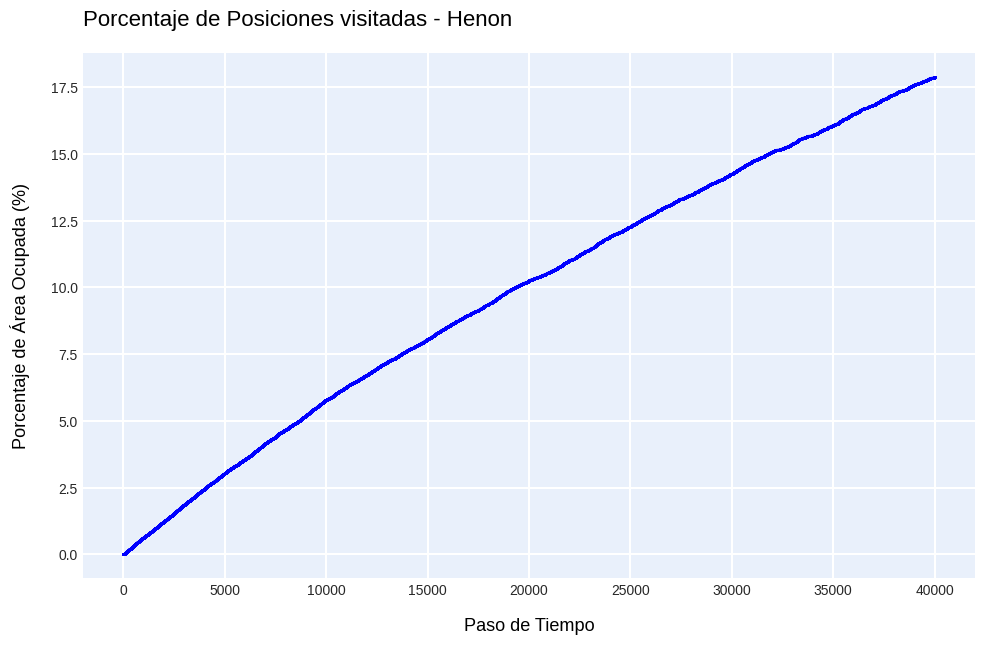

In [43]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()


### Serie Temporal y Espectro de Exponentes de Lyapunov - Henon (direcciones)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las direcciones seleccionadas por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las direcciones se concentran en un rango de aproximadamente 10 a 25, lo que indica una gran diversidad en las direcciones tomadas por el caminante. Hay episodios de alta variabilidad.
  - **Interpretación**: Esto sugiere que el caminante aleatorio tiene un comportamiento impredecible y variado en términos de direcciones.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de direcciones.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica que el sistema es localmente estable en muchas regiones, pero aún así presenta sensibilidad a las condiciones iniciales, lo cual es indicativo de comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 4.03390214989325
  - **Interpretación**: Este valor indica una complejidad moderada en la dinámica del sistema, con una estructura fractal típica de sistemas caóticos.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Henon (distancia)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las distancias recorridas en cada paso por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las distancias se concentran principalmente en valores entre 5 y 8.
  - **Interpretación**: Esto sugiere que el caminante realiza desplazamientos pequeños y medianos con más frecuencia.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de distancias.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia de exponentes negativos refuerza la idea de regiones de estabilidad local, aunque con comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 4.138906299937377
  - **Interpretación**: Este valor sugiere una dinámica compleja y caótica en el movimiento del caminante, con una estructura fractal.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Henon (choques)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de los choques (colisiones) del caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Los choques se concentran en un rango de aproximadamente 0 a 6, con una alta variabilidad.
  - **Interpretación**: Esto indica un comportamiento impredecible y variado en términos de choques.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de choques.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica estabilidad local en muchas regiones, aunque con comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 1.0260431731713948
  - **Interpretación**: Este valor indica una menor complejidad en la dinámica del sistema comparado con las gráficas anteriores, aunque todavía presenta una estructura fractal y comportamiento caótico.


## Atractor Rossler

![rossler](datos/Rossler/Rossler2.png)


### Direcciones

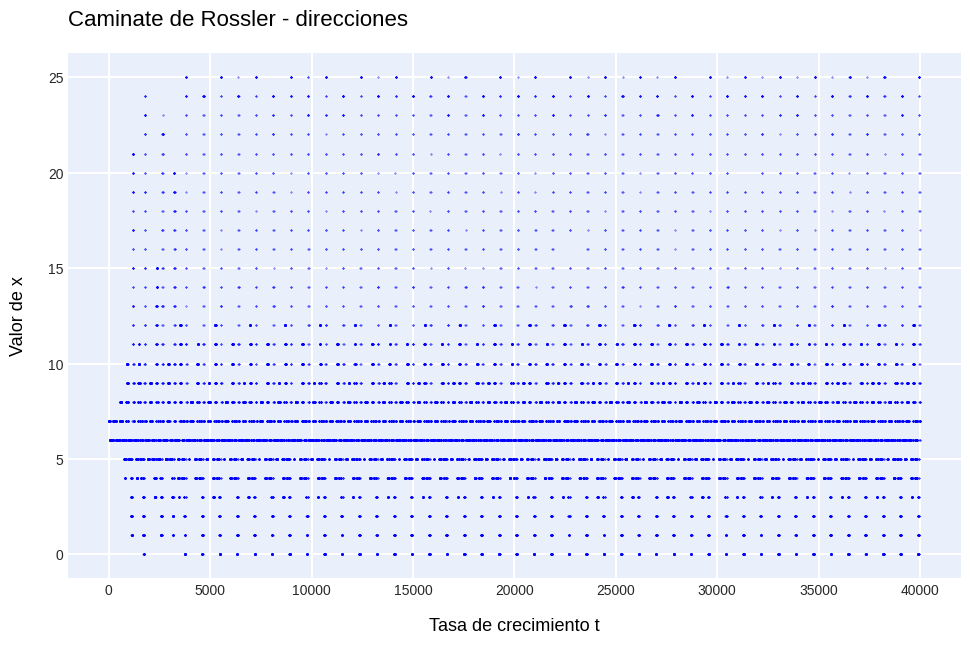

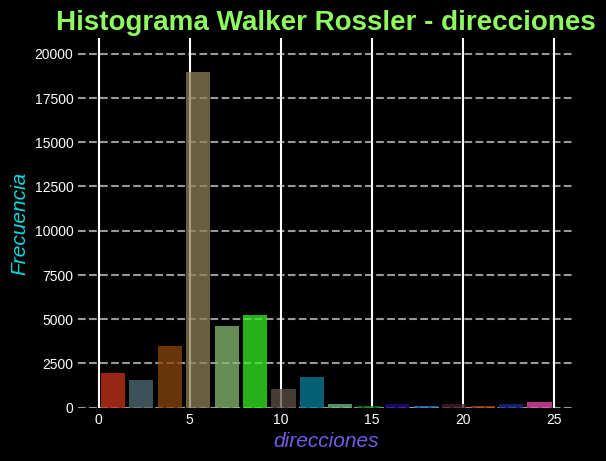

In [44]:
modelo = "transfrossler"
metrica = "direcciones"
folder = "Rossler"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (6.525): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 6.525.

Mediana (6.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 6 y la otra mitad son mayores o iguales a 6.

Moda (6, 13919): La moda muestra que la dirección 6 es la más frecuente, seleccionada 13,919 veces, lo que indica una fuerte preferencia del caminante por moverse en esta dirección.

Desviación Estándar (3.421): La desviación estándar de 3.421 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

Varianza (11.704): La varianza de 11.704 confirma una alta dispersión en las direcciones seleccionadas.

Asimetría (2.231): La asimetría de 2.231 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (9.151): La curtosis de 9.151 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (2.237): La entropía de 2.237 indica un nivel moderado de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.


### Exponentes de lyapounov y Kaplan Yorke

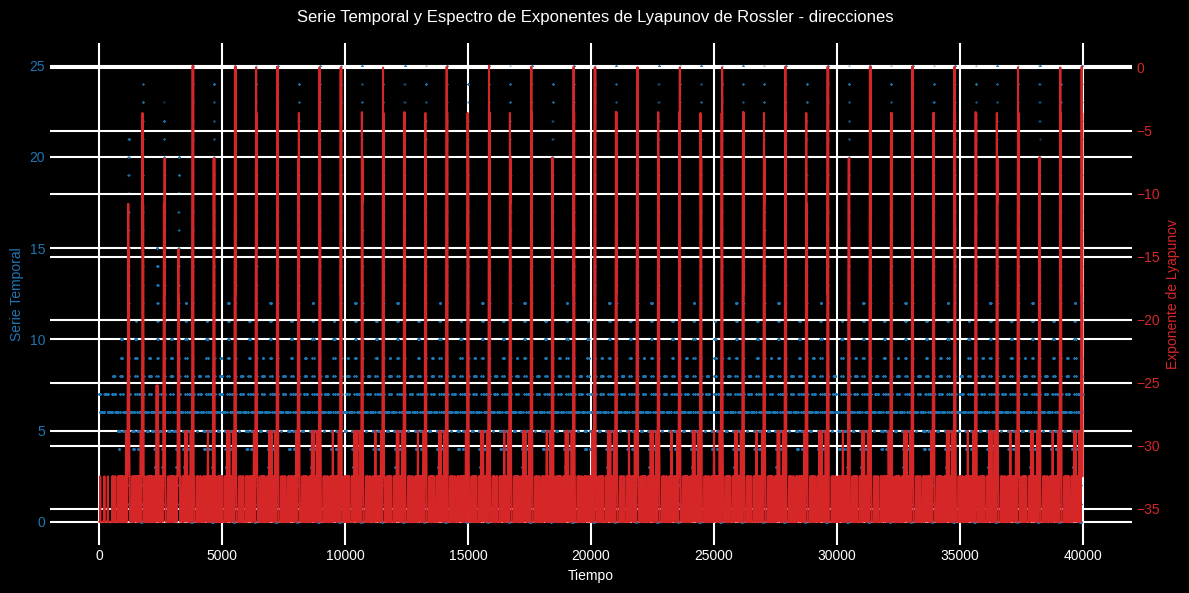

La dimension de Kaplan York es: 6.0


In [45]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Distancias

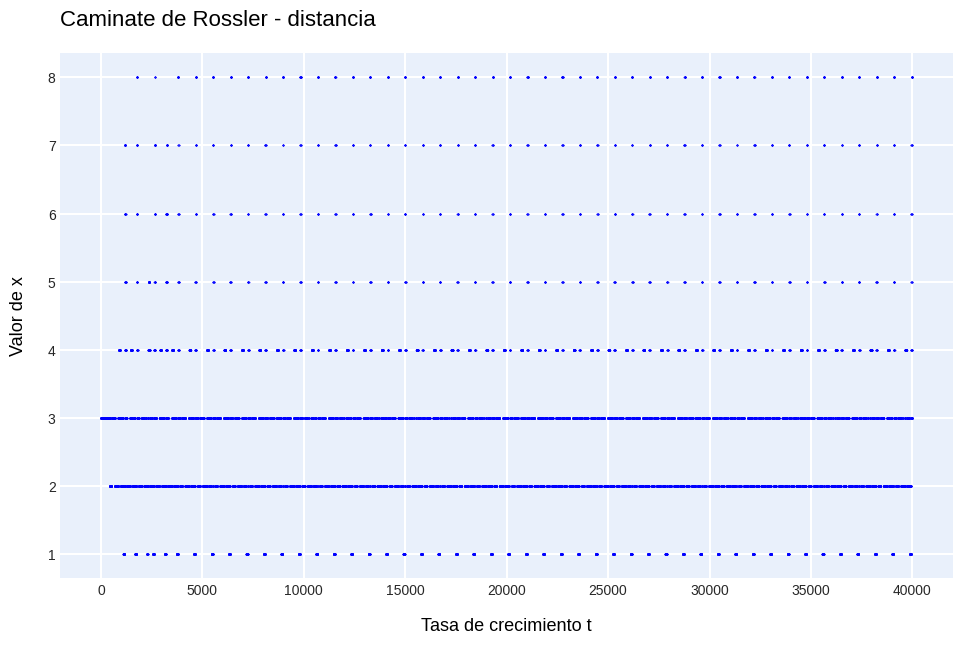

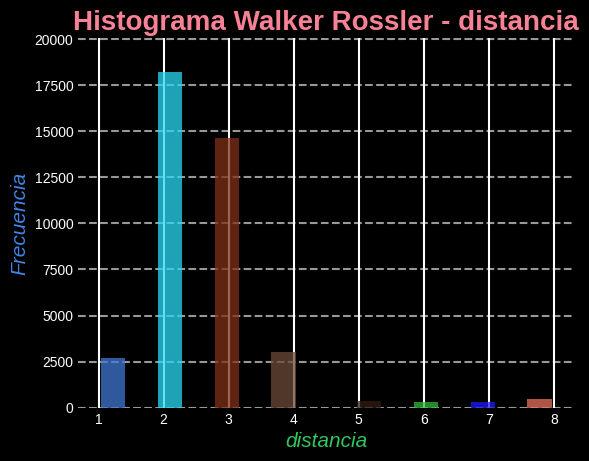

In [46]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (2.615): La media indica que, en promedio, el caminante avanza aproximadamente 2.615 unidades por movimiento.

Mediana (2.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 2 y la otra mitad son mayores o iguales a 2.

Moda (2, 18249): La moda muestra que la distancia de 2 unidades es la más frecuente, seleccionada 18,249 veces, lo que indica una fuerte preferencia por esta distancia.

Desviación Estándar (1.081): La desviación estándar de 1.081 sugiere una baja variabilidad en las distancias recorridas.

Varianza (1.168): La varianza de 1.168 confirma la observación de la desviación estándar, indicando una baja dispersión en las distancias recorridas.

Asimetría (2.152): La asimetría de 2.152 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (7.807): La curtosis de 7.807 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (1.27): La entropía de 1.27 indica un nivel bajo de incertidumbre en la selección de distancias.


### Exponentes de lyapounov y Kaplan Yorke

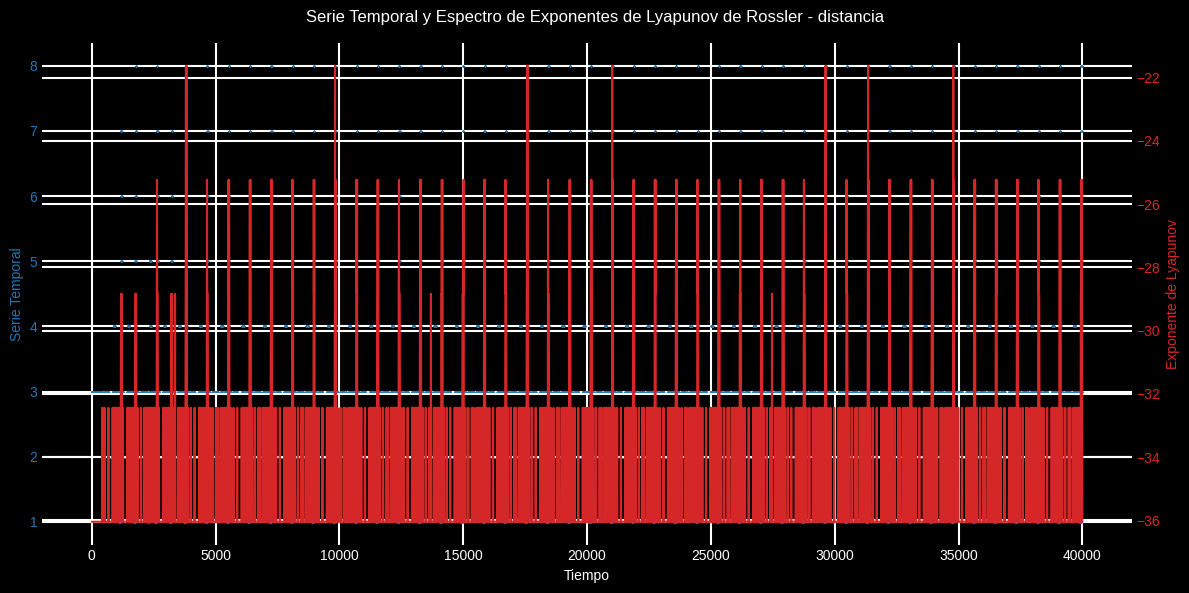

La dimension de Kaplan York es: 0.0


In [47]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Choques

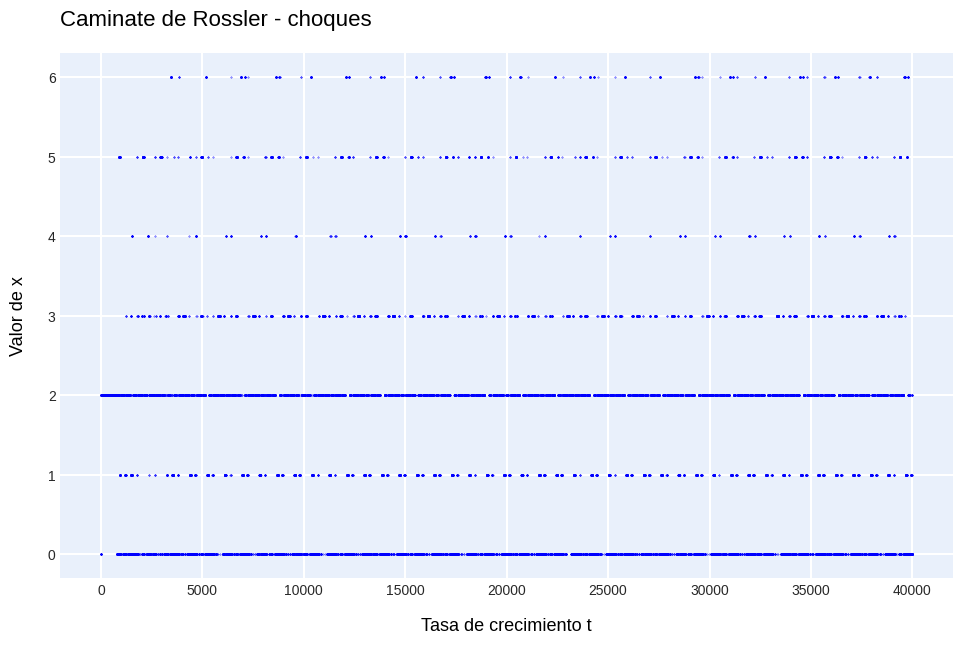

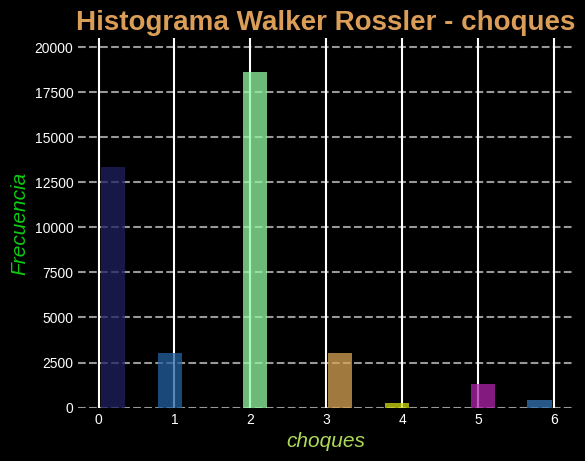

In [48]:
metrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (1.485): La media indica que, en promedio, el caminante choca con las paredes del cubo aproximadamente 1.485 veces por movimiento.

Mediana (2.0): La mediana sugiere que la mitad de los movimientos resultan en choques con la pared 2 o menor.

Moda (2, 18638): La moda muestra que la pared 2 es la más frecuente, ocurriendo 18,638 veces.

Desviación Estándar (1.307): La desviación estándar de 1.307 sugiere una variabilidad considerable en la pared de choque.

Varianza (1.709): La varianza de 1.709 confirma una alta dispersión en la pared de choque.

Asimetría (0.765): La asimetría de 0.765 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (0.987): La curtosis de 0.987 indica que la distribución es ligeramente más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (1.303): La entropía de 1.303 indica un nivel moderado de incertidumbre en la ocurrencia de choques.


### Exponentes de lyapounov y Kaplan yORKE

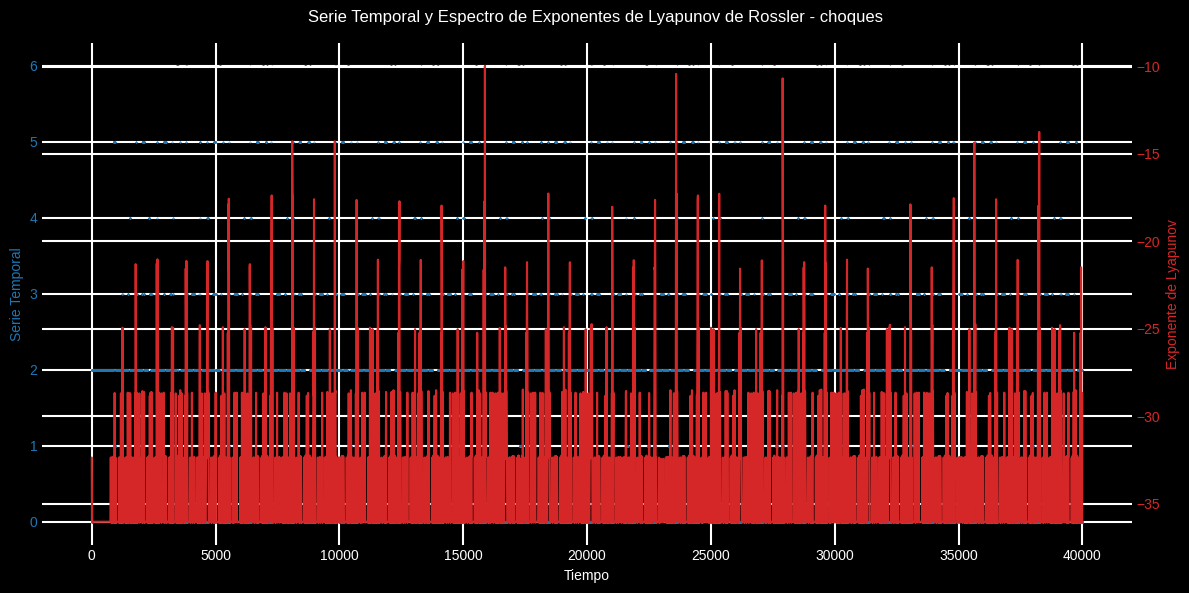

La dimension de Kaplan York es: 0.09080328696532036


In [49]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Posiciones


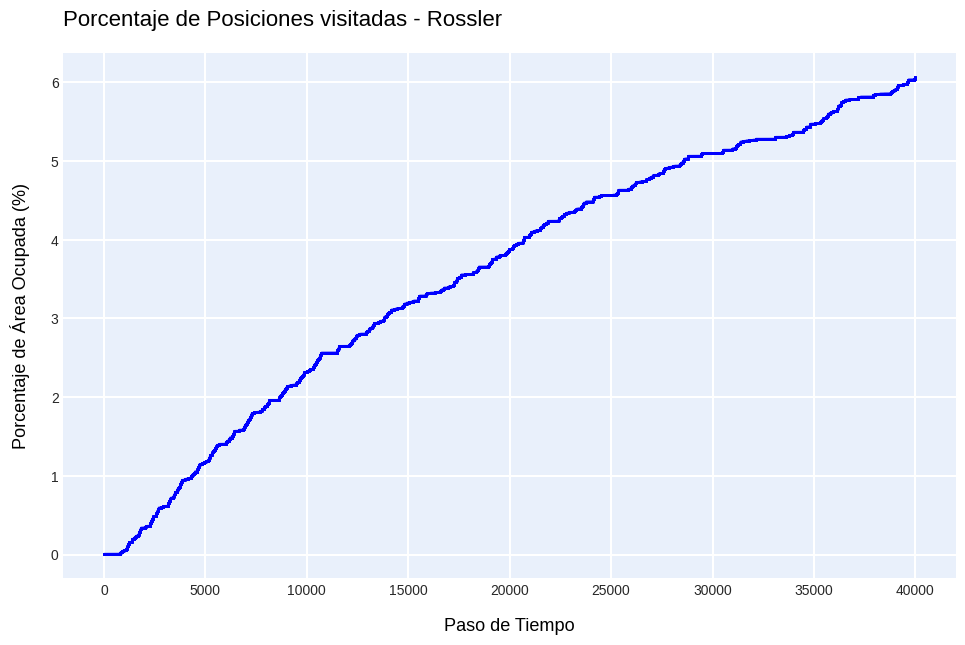

In [50]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

Media (39.776, 27.206, 14.845): La media indica que, en promedio, las posiciones visitadas por el caminante están alrededor de estos valores en el espacio tridimensional, con un sesgo hacia ciertas áreas del cubo.

Mediana (49.0, 28.0, 13.0): La mediana sugiere que la mitad de las posiciones visitadas se encuentran por debajo de estos valores, indicando una concentración en ciertas áreas del cubo.

Moda ([49, 49, 0], [23332, 3995, 11614]): La moda muestra que ciertas posiciones específicas son visitadas con mucha más frecuencia que otras, lo que indica una fuerte preferencia o patrón repetitivo en el movimiento del caminante.

Desviación Estándar (15.166, 14.486, 14.605): La desviación estándar indica una considerable variabilidad en las posiciones visitadas, especialmente en la primera y segunda dimensiones.

Varianza (230.014, 209.857, 213.317): La varianza confirma la alta dispersión en las posiciones visitadas, con una mayor dispersión en la primera dimensión.

Asimetría (-1.509, -0.262, 0.758): La asimetría sugiere que la distribución de las posiciones visitadas tiene diferentes sesgos en cada dimensión, con una distribución más equilibrada en la segunda dimensión y distribuciones sesgadas hacia valores menores en las otras dos dimensiones.

Coeficiente de Variación (0.381, 0.532, 0.984): El coeficiente de variación indica que hay una relativa consistencia en la exploración a lo largo de las dimensiones, con la primera y segunda dimensiones mostrando más variabilidad relativa.

Curtosis (0.838, -0.733, -0.538): La curtosis negativa en las últimas dos dimensiones indica que las posiciones visitadas tienen distribuciones más planas en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (2.205, 3.523, 3.138): La entropía indica un nivel moderado a alto de incertidumbre en la exploración de posiciones, lo que sugiere un balance entre aleatoriedad y repetición en el movimiento del caminante.


### Serie Temporal y Espectro de Exponentes de Lyapunov - Rossler (direcciones)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las direcciones seleccionadas por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las direcciones se concentran en un rango de aproximadamente 0 a 25, con patrones repetitivos y picos altos.
  - **Interpretación**: Esto sugiere un comportamiento cíclico con direcciones que varían de manera predecible en ciertos intervalos.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de direcciones.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica estabilidad local en muchas regiones, con un comportamiento menos caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 6.0
  - **Interpretación**: Este valor indica una complejidad alta en la dinámica del sistema, con una estructura fractal más desarrollada.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Rossler (distancia)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las distancias recorridas en cada paso por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las distancias se concentran principalmente en valores entre 1 y 8, con picos regulares.
  - **Interpretación**: Esto sugiere que el caminante realiza desplazamientos pequeños y medianos de manera predecible.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de distancias.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia de exponentes negativos refuerza la idea de estabilidad local, con un comportamiento menos caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 0.0
  - **Interpretación**: Este valor indica una falta de complejidad en la dinámica del sistema, sugiriendo un comportamiento más regular y predecible.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Rossler (choques)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de los choques (colisiones) del caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Los choques se concentran en un rango de aproximadamente 0 a 6, con alta variabilidad.
  - **Interpretación**: Esto indica un comportamiento impredecible y variado en términos de choques.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de choques.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica estabilidad local en muchas regiones, aunque con comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 0.09080328696532036
  - **Interpretación**: Este valor sugiere una menor complejidad en la dinámica del sistema comparado con las gráficas de direcciones, aunque todavía presenta cierta estructura fractal y comportamiento caótico.


## Atractor Lorentz

![Ejemplo de imagen](datos/Lorentz/Lorentz2.png)


### Direcciones

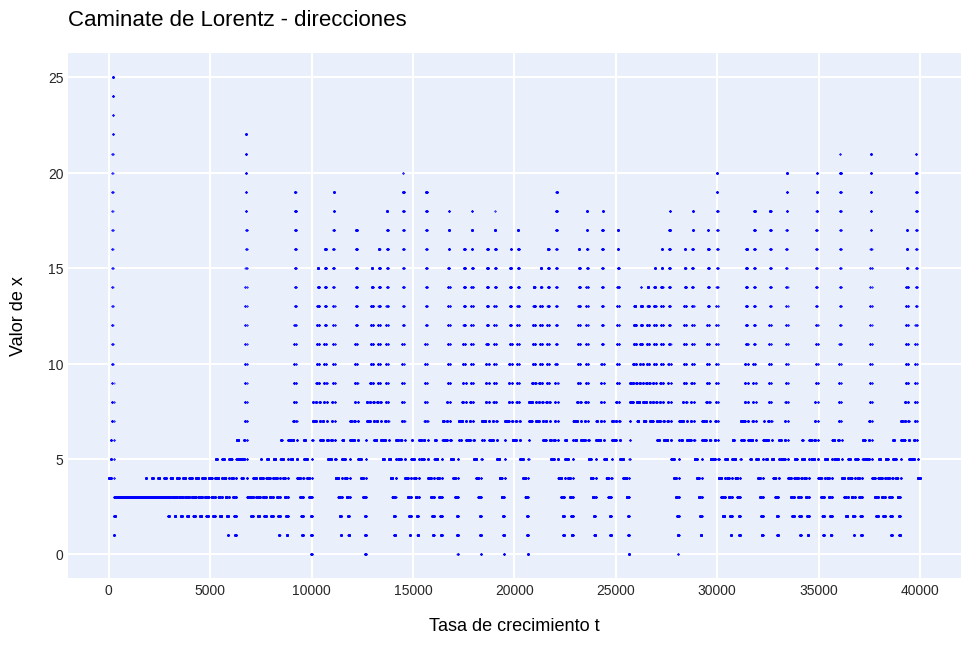

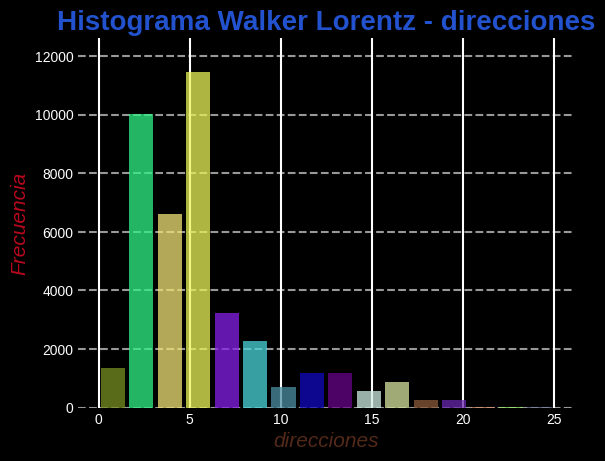

In [51]:
modelo = "transflorentz"
metrica = "direcciones"
folder = "Lorentz"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (5.737): La media indica que, en promedio, las direcciones seleccionadas por el caminante están alrededor del índice 5.737.

Mediana (5.0): La mediana sugiere que la mitad de las direcciones seleccionadas son menores o iguales a 5 y la otra mitad son mayores o iguales a 5.

Moda (3, 7023): La moda muestra que la dirección 3 es la más frecuente, seleccionada 7,023 veces, lo que indica una fuerte preferencia del caminante por moverse en esta dirección.

Desviación Estándar (3.718): La desviación estándar de 3.718 indica que las direcciones seleccionadas varían considerablemente alrededor de la media.

Varianza (13.823): La varianza de 13.823 confirma una alta dispersión en las direcciones seleccionadas.

Asimetría (1.682): La asimetría de 1.682 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (2.897): La curtosis de 2.897 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (2.44): La entropía de 2.44 indica un nivel moderado de incertidumbre o aleatoriedad en las direcciones seleccionadas por el caminante.


### Exponentes de lyapounov Y kAPLAN yORKE

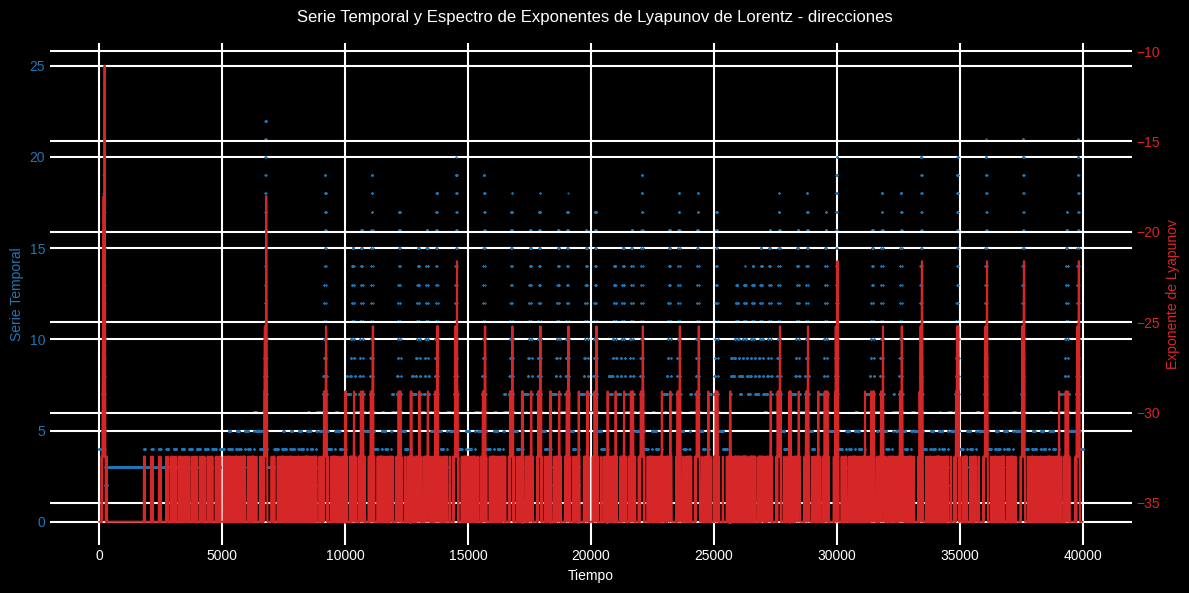

La dimension de Kaplan York es: 0.5999999999999999


In [52]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Distancias

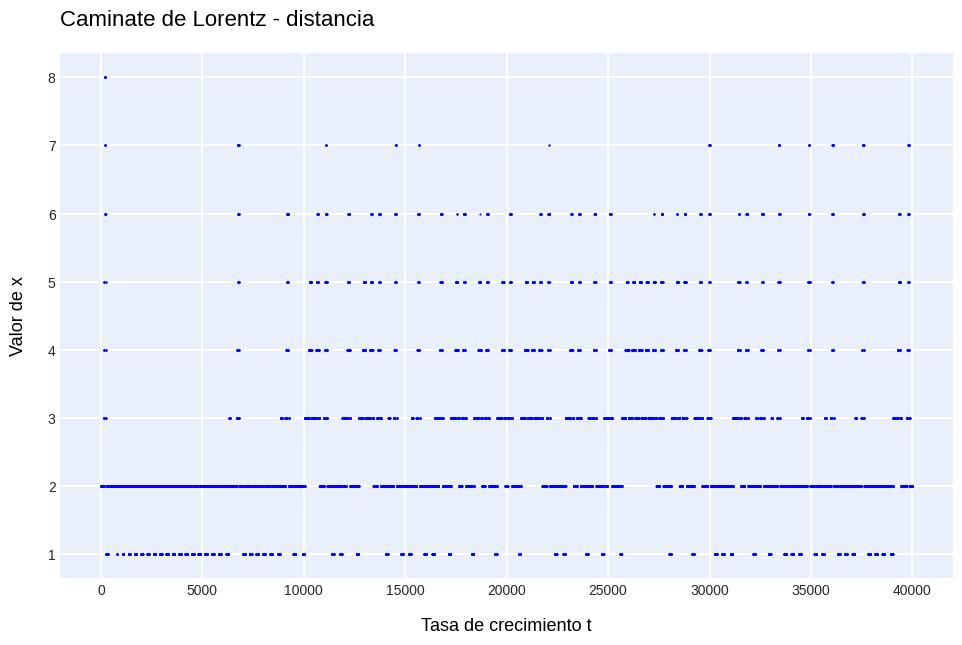

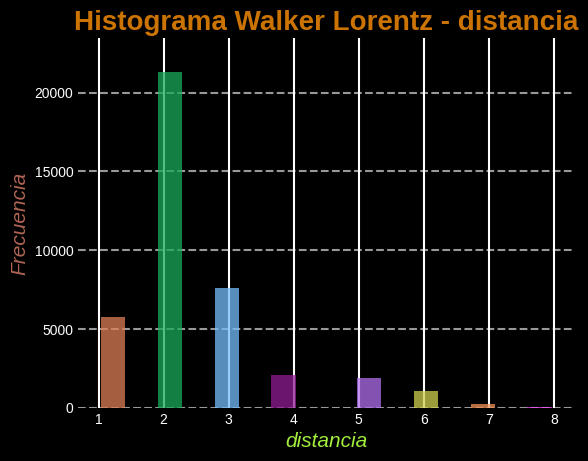

In [53]:
metrica = "distancia"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (2.431): La media indica que, en promedio, el caminante avanza aproximadamente 2.431 unidades por movimiento.

Mediana (2.0): La mediana sugiere que la mitad de las distancias recorridas son menores o iguales a 2 y la otra mitad son mayores o iguales a 2.

Moda (2, 21332): La moda muestra que la distancia de 2 unidades es la más frecuente, seleccionada 21,332 veces, lo que indica una fuerte preferencia por esta distancia.

Desviación Estándar (1.175): La desviación estándar de 1.175 sugiere una baja variabilidad en las distancias recorridas.

Varianza (1.38): La varianza de 1.38 confirma la observación de la desviación estándar, indicando una baja dispersión en las distancias recorridas.

Asimetría (1.52): La asimetría de 1.52 sugiere que la distribución está sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (2.547): La curtosis de 2.547 indica que la distribución es más puntiaguda en comparación con una distribución normal, sugiriendo más valores extremos.

Entropía (1.359): La entropía de 1.359 indica un nivel bajo de incertidumbre en la selección de distancias.


### Exponentes de lyapounov y Kaplan Yorke

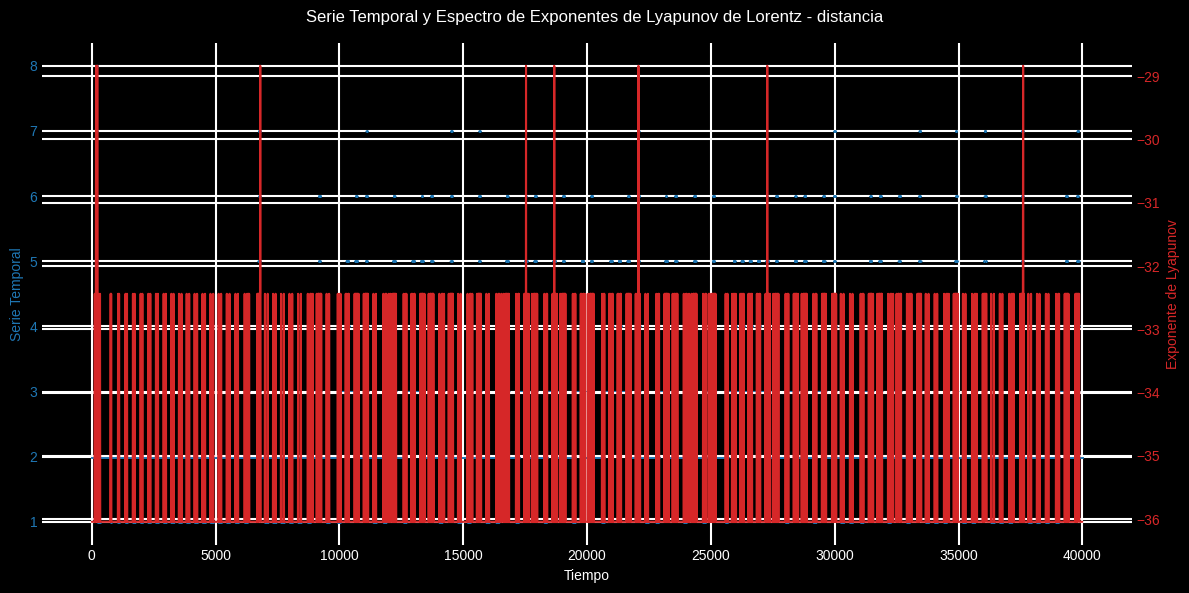

La dimension de Kaplan York es: 0.0


In [54]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Choques

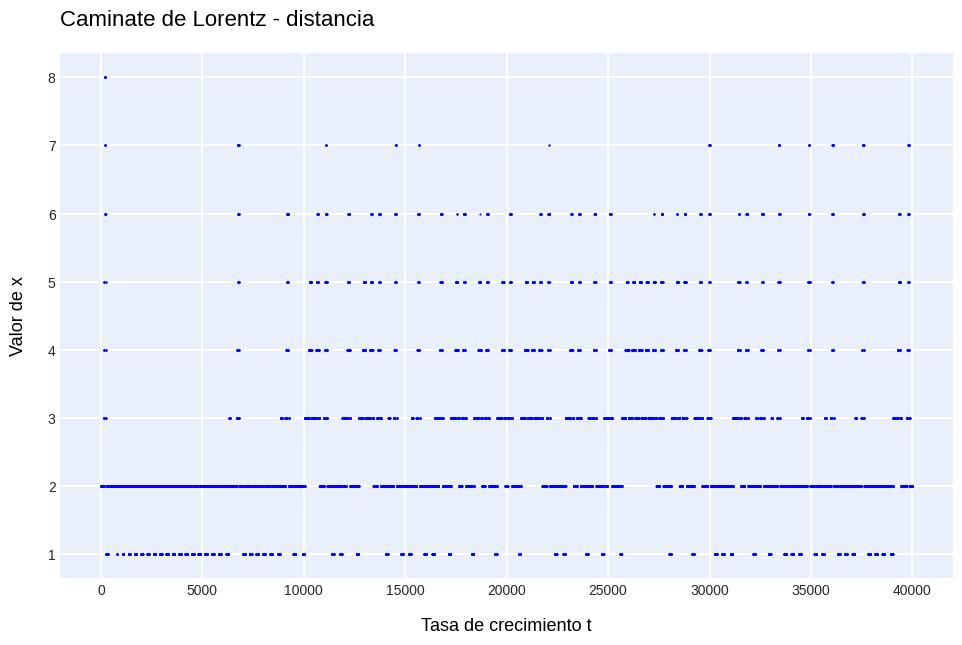

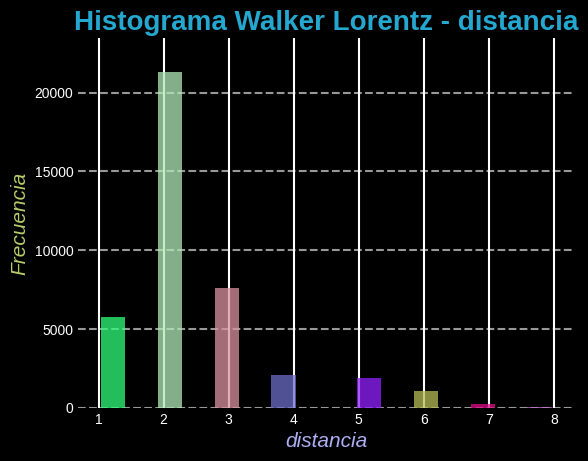

In [55]:
### Exponentes de lyapounovmetrica = "choques"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ",")
tiempo = range(1, 40001)
graficar(walker_feig, tiempo, width=7, height=5 ,titulo=f"Caminate de {folder} - {metrica}")
plotear_hist(walker_feig, f"Histograma Walker {folder} - {metrica}", metrica, "Frecuencia")
ex = DistribucionProbabilidad(walker_feig)
res = ex.calcular_metricas([25, 50, 75], [1, 2, 3])

#### Interpretación de las Métricas

Media (2.077): La media indica que, en promedio, el caminante choca con las paredes del cubo aproximadamente 2.077 veces por movimiento.

Mediana (2.0): La mediana sugiere que la mitad de los movimientos resultan en choques con la pared 2 o menor.

Moda (2, 12580): La moda muestra que la pared 2 es la más frecuente, ocurriendo 12,580 veces.

Desviación Estándar (1.495): La desviación estándar de 1.495 sugiere una variabilidad considerable en la pared de choque.

Varianza (2.234): La varianza de 2.234 confirma una alta dispersión en la pared de choque.

Asimetría (0.283): La asimetría de 0.283 sugiere que la distribución está ligeramente sesgada hacia la derecha, indicando una cola más larga en el lado derecho de la distribución.

Curtosis (0.079): La curtosis de 0.079 indica que la distribución es casi normal, sugiriendo valores extremos similares a una distribución normal.

Entropía (1.502): La entropía de 1.502 indica un nivel moderado de incertidumbre en la ocurrencia de choques.


### Exponentes de lyapounov y Kaplan yORKE

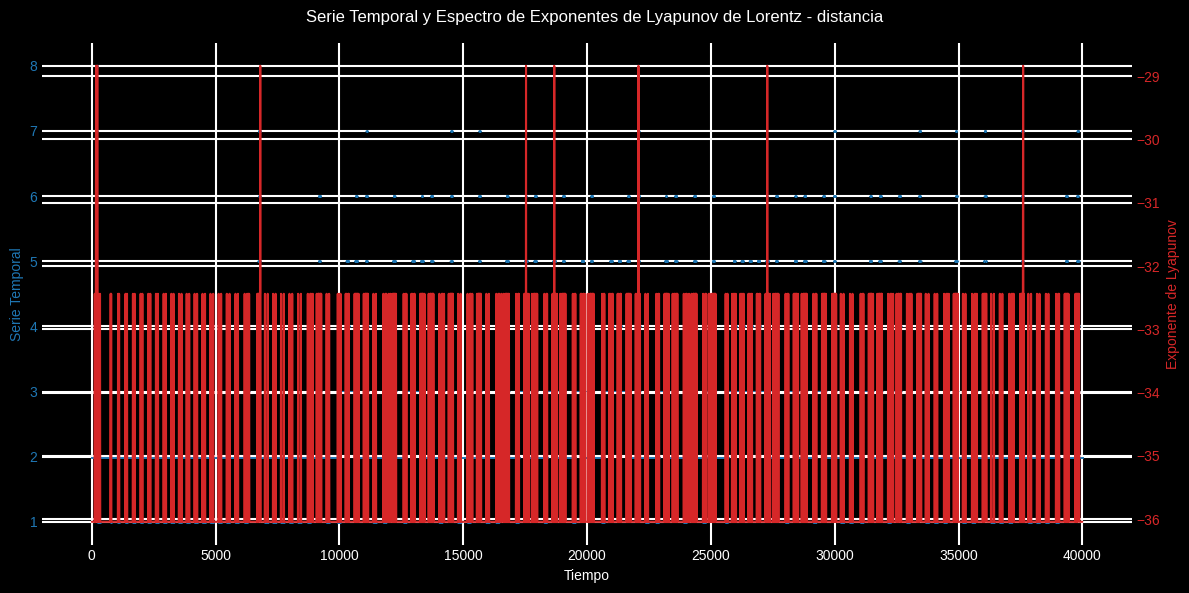

La dimension de Kaplan York es: 0.0


In [56]:
window_size = 10
lyapunov_exponents = plot_lyapunov_spectrum(walker_feig, window_size, folder, metrica)
dim_kaplan_yorke = dimension_kaplan_yorke(lyapunov_exponents)
print(f"La dimension de Kaplan York es: {dim_kaplan_yorke}")

### Posiciones

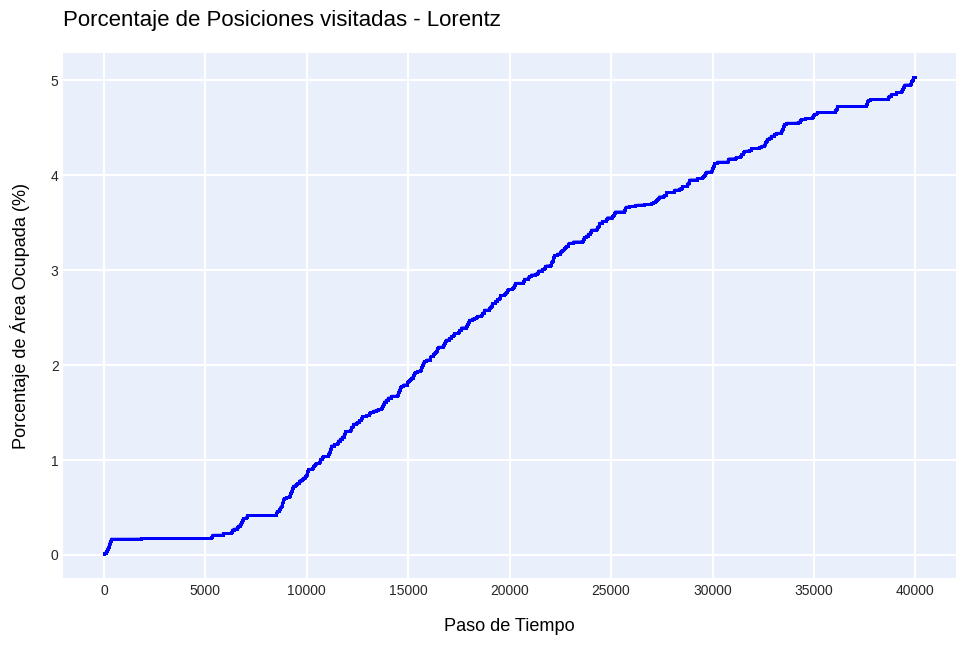

In [57]:
metrica = "posiciones"
walker_feig = cargar_csv(f"datos/{folder}/{metrica}_{modelo}0.txt", ";")

graficar_posicionesOcupadas(49, walker_feig, title=f"Porcentaje de Posiciones visitadas - {folder}")
ex = DistribucionProbabilidadVector(np.array(walker_feig))
res = ex.calcular_metricas()

#### Interpretación de las Métricas

Media (24.814, 32.707, 29.064): La media indica que, en promedio, las posiciones visitadas por el caminante están alrededor de estos valores en el espacio tridimensional, con un sesgo hacia ciertas áreas del cubo.

Mediana (27.0, 35.0, 32.0): La mediana sugiere que la mitad de las posiciones visitadas se encuentran por debajo de estos valores, indicando una concentración en ciertas áreas del cubo.

Moda ([0, 49, 49], [14650, 15071, 14979]): La moda muestra que ciertas posiciones específicas son visitadas con mucha más frecuencia que otras, lo que indica una fuerte preferencia o patrón repetitivo en el movimiento del caminante.

Desviación Estándar (21.873, 15.764, 19.215): La desviación estándar indica una considerable variabilidad en las posiciones visitadas, especialmente en la primera y tercera dimensiones.

Varianza (478.427, 248.493, 369.233): La varianza confirma la alta dispersión en las posiciones visitadas, con una mayor dispersión en la primera dimensión.

Asimetría (-0.046, -0.413, -0.34): La asimetría sugiere que la distribución de las posiciones visitadas tiene diferentes sesgos en cada dimensión, con una distribución más equilibrada en la segunda dimensión y distribuciones ligeramente sesgadas hacia valores menores en las otras dos dimensiones.

Coeficiente de Variación (0.881, 0.482, 0.661): El coeficiente de variación indica que hay una relativa consistencia en la exploración a lo largo de las dimensiones, con la primera y tercera dimensiones mostrando más variabilidad relativa.

Curtosis (-1.801, -1.146, -1.44): La curtosis negativa en todas las dimensiones indica que las posiciones visitadas tienen distribuciones más planas en comparación con una distribución normal, sugiriendo menos valores extremos.

Entropía (2.148, 2.894, 2.529): La entropía indica un nivel moderado de incertidumbre en la exploración de posiciones, lo que sugiere un balance entre aleatoriedad y repetición en el movimiento del caminante.


### Serie Temporal y Espectro de Exponentes de Lyapunov - Lorentz (direcciones)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las direcciones seleccionadas por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las direcciones se concentran en un rango de aproximadamente 0 a 25, con patrones de picos altos y variabilidad.
  - **Interpretación**: Esto sugiere un comportamiento cíclico y variado en términos de direcciones tomadas por el caminante.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de direcciones.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica estabilidad local en muchas regiones, aunque con un comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 0.5999999999999999
  - **Interpretación**: Este valor indica una baja complejidad en la dinámica del sistema, con una estructura fractal menos desarrollada.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Lorentz (distancia)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de las distancias recorridas en cada paso por el caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Las distancias se concentran principalmente en valores entre 1 y 8, con patrones repetitivos y predecibles.
  - **Interpretación**: Esto sugiere que el caminante realiza desplazamientos pequeños y medianos de manera regular.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de distancias.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia de exponentes negativos refuerza la idea de estabilidad local, con un comportamiento más regular y menos caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 0.0
  - **Interpretación**: Este valor indica una falta de complejidad en la dinámica del sistema, sugiriendo un comportamiento más regular y predecible.

---

### Serie Temporal y Espectro de Exponentes de Lyapunov - Lorentz (choques)

- **Serie Temporal**: 
  - **Descripción**: La gráfica muestra la evolución de los choques (colisiones) del caminante aleatorio a lo largo del tiempo.
  - **Observaciones**: Los choques se concentran en un rango de aproximadamente 0 a 8, con alta variabilidad y picos regulares.
  - **Interpretación**: Esto indica un comportamiento impredecible y variado en términos de choques.

- **Exponentes de Lyapunov**: 
  - **Descripción**: Los exponentes de Lyapunov están superpuestos a la serie temporal de choques.
  - **Observaciones**: Predominan los exponentes negativos.
  - **Interpretación**: La presencia predominante de exponentes negativos indica estabilidad local en muchas regiones, aunque con comportamiento caótico.

- **Dimensión de Kaplan-Yorke**: 
  - **Valor**: 0.0
  - **Interpretación**: Este valor sugiere una menor complejidad en la dinámica del sistema comparado con las gráficas de direcciones, aunque todavía presenta cierta estructura fractal y comportamiento caótico.
